In [40]:
import numpy as np
# import packages
import pandas as pd

In [48]:
# read in features
df_features = pd.read_pickle('ebw_raw_features_base_h1.pkl')

In [49]:
df_hits_tracker = pd.read_pickle('ebw_hits_tracker_h1.pkl')

In [50]:
df_features= df_features.join(df_hits_tracker.set_index(['call_letters', 'mediabase_id'])['cuml_song_station_spins_non_on_max'], on=['call_letters', 'mediabase_id'])

In [51]:
# first spin year
df_features['first_spin_year'] = df_features['first_spin_date'].dt.year

In [52]:
# hit year
df_features['hit_tag_year'] = df_features['hit_tag_date'].dt.year

#### quick detour to create spins to burn from hit bucket

In [53]:
df_features = df_features.join(df_hits_tracker.set_index(['call_letters', 'mediabase_id'])['spins_to_burnout_from_hit'], on=['call_letters', 'mediabase_id'], rsuffix='_revised')

In [54]:
df_features['spins_to_burnout_curr'] = (df_features['spins_to_burnout_from_hit_revised'] + df_features['cuml_song_station_spins_non_on_at_hit']) - df_features['cuml_song_station_spins_non_on']

In [55]:
df_features = df_features.join(df_hits_tracker.set_index(['call_letters', 'mediabase_id'])['censoring_flg'], on=['call_letters', 'mediabase_id'])

In [56]:
df_features['hit_spins_bucket_curr'] = pd.cut(df_features['cuml_song_station_spins_non_on_at_hit'], bins=[0, 200, 500, round(np.max(df_hits_tracker['cuml_song_station_spins_non_on_at_hit'])/100)*100], labels=['early', 'mid', 'late'])

In [57]:
df_features

,mediabase_id,song_id,call_letters,market_name,artist_id,format_code,song_release_date,first_callout_date,last_callout_date,first_spin_date,...,station_spins_total,station_spins_non_on,station_spins_am_pm_dr,cuml_song_station_spins_non_on_max,first_spin_year,hit_tag_year,spins_to_burnout_from_hit_revised,spins_to_burnout_curr,censoring_flg,hit_spins_bucket_curr
0,1086587,90090779,KHTS-FM,San Diego,26365333,H1,2022-06-01,2022-07-18,2023-01-02,2022-06-12,...,2480,1807,1249,1274,2022,2022,193.0,1171.0,True,late
1,1086587,90090779,KHTS-FM,San Diego,26365333,H1,2022-06-01,2022-07-18,2023-01-02,2022-06-12,...,2481,1794,1247,1274,2022,2022,193.0,1155.0,True,late
2,1086587,90090779,KHTS-FM,San Diego,26365333,H1,2022-06-01,2022-07-18,2023-01-02,2022-06-12,...,2460,1790,1234,1274,2022,2022,193.0,1136.0,True,late
3,1086587,90090779,KHTS-FM,San Diego,26365333,H1,2022-06-01,2022-07-18,2023-01-02,2022-06-12,...,2547,1864,1297,1274,2022,2022,193.0,1105.0,True,late
4,1086587,90090779,KHTS-FM,San Diego,26365333,H1,2022-06-01,2022-07-18,2023-01-02,2022-06-12,...,2491,1794,1237,1274,2022,2022,193.0,1068.0,True,late
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656602,2865765,2321893248,WZFT-FM,Baltimore,28054077,H1,2022-12-01,2023-01-30,2023-05-15,2023-01-01,...,2246,1622,1099,869,2023,2023,616.0,369.0,False,mid
656603,2865765,2321893248,WZFT-FM,Baltimore,28054077,H1,2022-12-01,2023-01-30,2023-05-15,2023-01-01,...,2245,1631,1095,869,2023,2023,616.0,272.0,False,mid
656604,2865765,2321893248,WZFT-FM,Baltimore,28054077,H1,2022-12-01,2023-01-30,2023-05-15,2023-01-01,...,2218,1607,1095,869,2023,2023,616.0,181.0,False,mid
656605,2865765,2321893248,WZFT-FM,Baltimore,28054077,H1,2022-12-01,2023-01-30,2023-05-15,2023-01-01,...,2256,1644,1101,869,2023,2023,616.0,87.0,False,mid


##### train-test split and setup

In [59]:
# Extract max spins for songs turned hit in 2020/2021/2022 upto May end 2022
mask = (df_features['hit_tag_year'] >= 2020) & (df_features['hit_tag_year'] <= 2022) & (df_features['hit_tag_date'] <= '2022-05-31')

df_join = df_features.loc[mask]

In [132]:
df_join.groupby(['weeks_since_hit', 'censoring_flg'])['mediabase_id'].count()

weeks_since_hit  censoring_flg
-219.0           False             1
-218.0           False             1
-217.0           False             1
-216.0           False             1
-215.0           False             1
                                  ..
 166.0           True             32
 167.0           False             6
                 True             18
 168.0           False             6
                 True             18
Name: mediabase_id, Length: 730, dtype: int64

In [133]:
df_join[df_join['weeks_since_hit'] == 32]

,mediabase_id,song_id,call_letters,market_name,artist_id,format_code,song_release_date,first_callout_date,last_callout_date,first_spin_date,...,station_spins_total,station_spins_non_on,station_spins_am_pm_dr,cuml_song_station_spins_non_on_max,first_spin_year,hit_tag_year,spins_to_burnout_from_hit_revised,spins_to_burnout_curr,censoring_flg,hit_spins_bucket_curr
159300,2305938,263030694,KZHT-FM,Salt Lake City,26406068,H1,2017-06-01,2017-10-30,2022-12-05,2017-08-06,...,2230,1554,1051,1972,2017,2020,282.0,93.0,True,late
212809,2334402,288264701,KBKS-FM,Seattle,26372881,H1,2017-09-01,2018-07-02,2023-04-03,2018-04-29,...,2567,1844,1269,1321,2018,2021,459.0,243.0,False,late
228927,2337260,289012004,WRVW-FM,Nashville,28107987,H1,2017-09-01,2019-07-01,2022-05-16,2019-05-05,...,2492,1766,1198,2719,2019,2021,288.0,140.0,False,late
239949,2345185,290028019,WNCI-FM,"Columbus, OH",32041866,H1,2017-10-01,2018-05-07,2023-03-13,2018-02-25,...,2115,1505,1007,2358,2018,2022,36.0,7.0,False,late
244616,2345779,289998743,WKSC-FM,Chicago,28732541,H1,2017-10-01,2018-10-08,2021-05-24,2018-02-11,...,2248,1605,1081,1461,2018,2021,208.0,43.0,False,late
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650897,2794968,2192719467,WIOQ-FM,Philadelphia,32203736,H1,2022-03-01,2022-05-02,2023-05-22,2022-03-27,...,2283,1590,1065,3240,2022,2022,770.0,-1535.0,True,mid
650948,2794968,2192719467,WKSC-FM,Chicago,32203736,H1,2022-03-01,2022-05-09,2023-05-22,2022-03-27,...,2289,1672,1135,2923,2022,2022,1250.0,-921.0,True,mid
651109,2794968,2192719467,WXKS-FM,Boston,32203736,H1,2022-03-01,2022-04-18,2023-05-22,2022-03-27,...,2258,1601,1059,2876,2022,2022,1773.0,-193.0,True,late
651267,2797282,2202531222,KIIS-FM,Los Angeles,28649984,H1,2022-04-01,2022-04-25,2023-02-06,2022-04-03,...,2573,1844,1279,1300,2022,2022,534.0,-370.0,True,mid


In [139]:
mask = (df_join['mediabase_id'] == 2794968) & (df_join['call_letters'] == 'WKSC-FM')
df_join.loc[mask][['weeks_since_hit', 'spins_to_burnout_curr', 'censoring_flg']]

,weeks_since_hit,spins_to_burnout_curr,censoring_flg
650909,-7.0,1722.0,True
650910,-6.0,1693.0,True
650911,-5.0,1647.0,True
650912,-4.0,1600.0,True
650913,-3.0,1525.0,True
650914,-2.0,1432.0,True
650915,-1.0,1337.0,True
650916,0.0,1250.0,True
650917,1.0,1160.0,True
650918,2.0,1071.0,True


In [99]:
# Extract data for train test split
mask_wks = (df_join['weeks_since_hit'] > 0) & (df_join['spins_to_burnout_curr'] >= 0) & (df_join['song_station_spins_non_on'] > 0)
#target_cols = ['spins_to_burnout_from_hit_bucket']
target_cols = ['censoring_flg', 'spins_to_burnout_curr']
id_cols = ['mediabase_id', 'call_letters', 'weeks_since_hit', 'hit_tag_year']
cat_cols = ['market_name']
stratify_cols = ['censoring_flg']
df_all_prep = df_join.loc[mask_wks, id_cols + target_cols + cat_cols]
# df_all_prep = df_all_prep[~pd.isna(df_all_prep['hit_spins_bucket'])]
df_all_prep.set_index(id_cols, inplace=True)

In [80]:
week_start = 3
week_end = 52

weeks_range = list(range(week_start, week_end + 1))

In [100]:
from sklearn.model_selection import train_test_split
df_train_sets = pd.DataFrame()
df_test_sets = pd.DataFrame()
# training data & test data split
for wk in weeks_range:
    mask = (df_all_prep.index.get_level_values(2) == wk)
    df_train_prep, df_test_prep = train_test_split(df_all_prep.loc[mask], test_size=0.25, stratify=df_all_prep.loc[mask][stratify_cols], random_state=1000)
    df_train_sets = pd.concat([df_train_sets, df_train_prep])
    df_test_sets = pd.concat([df_test_sets, df_test_prep])

In [101]:
df_train_sets.groupby(['weeks_since_hit', 'censoring_flg'])[['spins_to_burnout_curr']].count(). join(df_test_sets.groupby(['weeks_since_hit', 'censoring_flg'])['spins_to_burnout_curr'].count(), rsuffix='_r')

spins_to_burnout_curr  spins_to_burnout_curr_r
weeks_since_hit censoring_flg                                                
3.0             False                            253                       84
                True                             670                      224
4.0             False                            250                       83
                True                             662                      221
5.0             False                            243                       81
...                                              ...                      ...
50.0            True                              34                       11
51.0            False                             95                       33
                True                              34                       11
52.0            False                             95                       32
                True                              34                       11

[100 rows x 2 columns]

In [103]:
# write train/test sets to a pickle file
df_train_sets.to_pickle('ebw_poc_training_sets_with_chg.pkl')
df_test_sets.to_pickle('ebw_poc_testing_sets_with_chg.pkl')

#### GBM

In [104]:
feature_col_types = ['pop', 'spins', 'streams', 'pct_chg', 'propn']

In [113]:
from sklearn.preprocessing import StandardScaler

In [121]:
X_train

,,,,,song_station_pop_1wk_lag1_min,song_station_pop_1wk_lag1_max,song_station_pop_1wk_lag1_mean,song_station_ddl_1wk_lag1_min,song_station_ddl_1wk_lag1_max,song_station_ddl_1wk_lag1_mean,song_station_fav_1wk_lag1_min,song_station_fav_1wk_lag1_max,song_station_fav_1wk_lag1_mean,count_song_format_pop_1wk_lag1_min,...,market_name_Pittsburgh,"market_name_Portland, OR",market_name_Raleigh,market_name_Salt Lake City,market_name_San Diego,market_name_San Francisco,market_name_Seattle,market_name_St. Louis,market_name_Tampa,"market_name_Washington, DC"
mediabase_id,call_letters,weeks_since_hit,hit_tag_year,week_dt,,,,,,,,,,,,,,,,,,,,,
2708592,KHKS-FM,3.0,2021,2021-07-11,2.062341,2.062341,2.062341,0.092672,0.092672,0.092672,3.022725,3.022725,3.022725,1.331070,...,-0.207215,-0.186423,-0.207215,-0.20146,-0.180107,-0.204354,-0.215604,-0.186423,-0.198531,-0.195564
2720462,WHTZ-FM,3.0,2021,2021-10-10,1.168120,1.168120,1.168120,-1.209906,-1.209906,-1.209906,0.424271,0.424271,0.424271,0.724665,...,-0.207215,-0.186423,-0.207215,-0.20146,-0.180107,-0.204354,-0.215604,-0.186423,-0.198531,-0.195564
2750191,KDWB-FM,3.0,2021,2021-12-19,0.912628,0.912628,0.912628,-0.558617,-0.558617,-0.558617,0.424271,0.424271,0.424271,0.118259,...,-0.207215,-0.186423,-0.207215,-0.20146,-0.180107,-0.204354,-0.215604,-0.186423,-0.198531,-0.195564
2552613,KHKS-FM,3.0,2020,2020-05-03,0.529391,0.529391,0.529391,-1.427002,-1.427002,-1.427002,1.188522,1.188522,1.188522,0.522529,...,-0.207215,-0.186423,-0.207215,-0.20146,-0.180107,-0.204354,-0.215604,-0.186423,-0.198531,-0.195564
2583267,WXXL-FM,3.0,2020,2020-07-26,-0.237084,-0.237084,-0.237084,0.743960,0.743960,0.743960,-1.409932,-1.409932,-1.409932,0.118259,...,-0.207215,-0.186423,-0.207215,-0.20146,-0.180107,-0.204354,-0.215604,-0.186423,-0.198531,-0.195564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2483822,KKRZ-FM,3.0,2021,2021-01-24,-1.259051,-1.259051,-1.259051,-0.558617,-0.558617,-0.558617,-1.104231,-1.104231,-1.104231,-1.903093,...,-0.207215,5.364158,-0.207215,-0.20146,-0.180107,-0.204354,-0.215604,-0.186423,-0.198531,-0.195564
2727194,KKRZ-FM,3.0,2021,2021-11-07,1.551358,1.551358,1.551358,-1.209906,-1.209906,-1.209906,1.035672,1.035672,1.035672,-0.083876,...,-0.207215,5.364158,-0.207215,-0.20146,-0.180107,-0.204354,-0.215604,-0.186423,-0.198531,-0.195564
2723707,KHFI-FM,3.0,2021,2021-10-24,-0.109338,-0.109338,-0.109338,0.309768,0.309768,0.309768,0.424271,0.424271,0.424271,0.118259,...,-0.207215,-0.186423,-0.207215,-0.20146,-0.180107,-0.204354,-0.215604,-0.186423,-0.198531,-0.195564


In [125]:
max_time

3386.0

In [130]:
df_y_temp.sort_values(by=['spins_to_burnout_curr'], ascending=False)

,,,,censoring_flg,spins_to_burnout_curr
mediabase_id,call_letters,weeks_since_hit,hit_tag_year,,
2625043,KSLZ-FM,4.0,2021,False,3000.0
2582475,KIIS-FM,4.0,2021,False,3000.0
2625043,WKST-FM,4.0,2021,True,3000.0
2655256,KSLZ-FM,4.0,2021,True,3000.0
2605093,WZFT-FM,4.0,2021,True,3000.0
...,...,...,...,...,...
2693277,WKFS-FM,4.0,2021,True,0.0
2716380,KYLD-FM,4.0,2022,True,0.0
2620824,KYLD-FM,4.0,2021,True,0.0


In [127]:
# train a gbm
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import as_concordance_index_ipcw_scorer
from sklearn.model_selection import RandomizedSearchCV
split_number=5
split_number=2

param_grid = {
    'estimator__max_depth': [2, 4, 6, 8, 10],
    'estimator__max_features': ['auto', 'sqrt'],
    'estimator__n_estimators': [50, 100, 150, 200],
    'estimator__learning_rate': [0.01, 0.001, 0.5, 0.1]
}

week_start = 3
week_end = 52

weeks_range = list(range(week_start, week_end + 1))
best_estimators = {}
best_scores = {}

for wk in weeks_range:
    df_features_coll = pd.DataFrame()
    for typ in feature_col_types:
        df_temp = pd.read_pickle(f'ebw_{typ}_features_h1.pkl')
        df_temp=df_temp[df_temp['weeks_since_hit'] == wk].set_index(['call_letters', 'mediabase_id', 'week_dt','weeks_since_hit'])
        if df_features_coll.shape[0] == 0:
            df_features_coll = pd.concat([df_features_coll, df_temp], axis=0)
        else:
            df_features_coll = df_features_coll.join(df_temp)

    sv = GradientBoostingSurvivalAnalysis()
    X_train = df_train_sets[df_train_sets.index.get_level_values(2) == wk][cat_cols].join(df_features_coll, how='left')
    print(X_train.shape)
    X_train.dropna(axis=1, how='any', inplace=True)
    print(X_train.shape)
    X_train = pd.get_dummies(X_train, columns=['market_name'])
    feature_cols = list(set(X_train.columns) - set('market_name'))
    X_train[feature_cols] = StandardScaler().fit_transform(X_train[feature_cols])
    df_y_temp = df_train_sets[df_train_sets.index.get_level_values(2) == wk][target_cols]
    max_time = np.max(df_y_temp[df_y_temp['censoring_flg'] == True]['spins_to_burnout_curr'])
    df_y_temp.loc[(df_y_temp['spins_to_burnout_curr'] > 3000), 'spins_to_burnout_curr'] = 3000
    y_train = df_y_temp.to_records(index=False)
    # train gbm model
    sv_model = RandomizedSearchCV(estimator=as_concordance_index_ipcw_scorer(sv), param_distributions=param_grid, cv=split_number, verbose=1, n_iter=50, n_jobs=-1)
    sv_model.fit(X_train, y_train)
    best_estimators[wk] = sv_model.best_estimator_
    best_scores[wk] = sv_model.best_score_
    print(str(wk) + '_' + 'best_score: ' + f'{sv_model.best_score_}')

(923, 2509)
(923, 2393)
Fitting 2 folds for each of 50 candidates, totalling 100 fits
3_best_score: 0.7336953728570008
(912, 2509)
(912, 2393)
Fitting 2 folds for each of 50 candidates, totalling 100 fits


/Users/girishhanumantha/Documents/GitHub/adds-early-burnout-warning-model/venv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  category=UserWarning,
/Users/girishhanumantha/Documents/GitHub/adds-early-burnout-warning-model/venv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/girishhanumantha/Documents/GitHub/adds-early-burnout-warning-model/venv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/girishhanumantha/Docum

KeyboardInterrupt: 

In [129]:
df_y_temp

,,,,censoring_flg,spins_to_burnout_curr
mediabase_id,call_letters,weeks_since_hit,hit_tag_year,,
2655256,KZHT-FM,4.0,2021,True,1792.0
2396687,WNCI-FM,4.0,2020,True,11.0
2723707,WKQI-FM,4.0,2021,True,1171.0
2708592,KIIS-FM,4.0,2021,True,1477.0
2672451,WHTZ-FM,4.0,2021,True,76.0
...,...,...,...,...,...
2531558,KKRZ-FM,4.0,2020,True,0.0
2555681,WFLZ-FM,4.0,2020,False,785.0
2750191,KDWB-FM,4.0,2021,True,276.0


In [126]:
y_train

rec.array([( True, 1.251e+03), (False, 2.285e+03), ( True, 3.750e+02),
           ( True, 1.823e+03), ( True, 9.890e+02), ( True, 1.792e+03),
           (False, 9.100e+01), (False, 3.620e+02), ( True, 1.800e+02),
           ( True, 3.230e+02), ( True, 7.340e+02), ( True, 6.770e+02),
           ( True, 1.432e+03), ( True, 4.830e+02), ( True, 8.070e+02),
           (False, 7.250e+02), (False, 1.412e+03), ( True, 1.510e+02),
           (False, 1.207e+03), ( True, 0.000e+00), ( True, 5.740e+02),
           ( True, 6.700e+01), ( True, 4.080e+02), ( True, 1.200e+02),
           ( True, 4.330e+02), ( True, 1.370e+03), ( True, 8.580e+02),
           ( True, 8.880e+02), ( True, 5.680e+02), (False, 4.440e+02),
           ( True, 7.810e+02), (False, 5.450e+02), ( True, 6.920e+02),
           ( True, 3.760e+02), (False, 1.530e+02), (False, 1.700e+01),
           ( True, 7.980e+02), ( True, 5.700e+01), (False, 2.200e+01),
           ( True, 2.824e+03), (False, 4.530e+02), ( True, 1.740e+02),
      

In [118]:
df_train_sets[df_train_sets.index.get_level_values(2) == wk][target_cols].sort_values(by=['spins_to_burnout_curr'])

,,,,censoring_flg,spins_to_burnout_curr
mediabase_id,call_letters,weeks_since_hit,hit_tag_year,,
2620824,KZZP-FM,4.0,2021,True,0.0
2687228,KBKS-FM,4.0,2021,True,0.0
2546146,KYLD-FM,4.0,2020,True,0.0
2544637,WZFT-FM,4.0,2020,True,0.0
2608883,WXKS-FM,4.0,2020,True,0.0
...,...,...,...,...,...
2655256,KSLZ-FM,4.0,2021,True,3009.0
2582475,KIIS-FM,4.0,2021,False,3073.0
2625043,WKST-FM,4.0,2021,True,3175.0


In [106]:
X_train

NameError: name 'X_train' is not defined

In [42]:
X_train.loc[:, X_train.isna().any()]

,,,,artist_station_spins_total_prior_8wk_min_pct_chg,min_completed_count_prior_unv_prior_13wk_max_pct_chg,artist_station_spins_am_pm_dr_prior_8wk_mean_pct_chg,min_completed_count_prior_unv_prior_26wk_max_pct_chg,song_station_spins_non_on_prior_8wk_min_pct_chg,med_thumbs_up_rate_prior_unv_prior_4wk_min_pct_chg,song_format_spins_non_on_prior_26wk_min_pct_chg,artist_spins_propn_prior_26wk_min_pct_chg,song_market_spins_non_on_prior_26wk_min_pct_chg,artist_market_spins_total_prior_13wk_min_pct_chg,...,mr_thumbs_up_rate_prior_unv_prior_26wk_mean_pct_chg,min_completed_rate_prior_unv_prior_26wk_max_pct_chg,med_thumbs_up_rate_prior_unv_prior_8wk_max_pct_chg,med_thumbs_up_rate_prior_unv_prior_13wk_mean_pct_chg,song_market_spins_total_prior_13wk_min_pct_chg,market_spins_propn_prior_8wk_min_pct_chg,min_completed_count_prior_unv_prior_26wk_min_pct_chg,min_thumbs_up_rate_prior_unv_prior_13wk_mean_pct_chg,song_station_spins_am_pm_dr_prior_4wk_min_pct_chg,artist_station_spins_non_on_prior_13wk_max_pct_chg
mediabase_id,call_letters,weeks_since_hit,hit_tag_year,,,,,,,,,,,,,,,,,,,,,
2552475,WHYI-FM,3.0,2020,0.232143,0.0,0.064356,0.0,0.208333,0.005333,0.000000,0.000000,0.0,0.000000,...,0.003977,0.0,0.001133,0.005301,0.000000,0.000000,0.0,-0.005428,0.000000,0.022556
2531558,KKRZ-FM,3.0,2020,-0.071429,0.0,-0.144828,0.0,0.000000,0.000173,0.000000,0.000000,0.0,0.000000,...,0.001232,0.0,0.001162,0.000546,0.000000,-0.035714,0.0,0.000000,0.000000,0.000000
2399249,KSLZ-FM,3.0,2020,0.000000,0.0,-0.011905,0.0,0.000000,0.000000,0.000000,0.000000,0.0,-0.093750,...,-0.000020,0.0,-0.016520,-0.000669,-0.022222,0.000000,0.0,0.000000,0.000000,0.000000
2552475,KDHT-FM,3.0,2022,0.000000,0.0,0.038549,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000552,0.0,0.000121,0.000090,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2691407,WHQC-FM,3.0,2022,0.000000,NaN,0.121212,NaN,0.000000,NaN,-0.079258,0.000000,0.0,0.000000,...,0.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.333333,-0.079365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2524291,KSLZ-FM,3.0,2020,0.000000,0.0,0.076923,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.560000,...,0.000966,0.0,0.000000,0.004617,0.560000,0.000000,0.0,0.000000,0.026316,0.020833
2654543,WHYI-FM,3.0,2021,0.000000,NaN,0.004717,NaN,0.000000,NaN,0.000000,-0.026667,0.0,0.000000,...,0.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.018519,0.000000
2727194,KHFI-FM,3.0,2022,0.723077,NaN,0.081466,NaN,1.153846,NaN,0.401636,0.000000,0.0,0.000000,...,0.000000,NaN,NaN,NaN,0.000000,0.559682,NaN,0.000000,-0.014706,0.000000


In [44]:
X_train.loc[((X_train.index.get_level_values(0) == 2345185) & (X_train.index.get_level_values(1) == 'WNCI-FM')), X_train.isna().any()]

,,,,artist_station_spins_total_prior_8wk_min_pct_chg,min_completed_count_prior_unv_prior_13wk_max_pct_chg,artist_station_spins_am_pm_dr_prior_8wk_mean_pct_chg,min_completed_count_prior_unv_prior_26wk_max_pct_chg,song_station_spins_non_on_prior_8wk_min_pct_chg,med_thumbs_up_rate_prior_unv_prior_4wk_min_pct_chg,song_format_spins_non_on_prior_26wk_min_pct_chg,artist_spins_propn_prior_26wk_min_pct_chg,song_market_spins_non_on_prior_26wk_min_pct_chg,artist_market_spins_total_prior_13wk_min_pct_chg,...,mr_thumbs_up_rate_prior_unv_prior_26wk_mean_pct_chg,min_completed_rate_prior_unv_prior_26wk_max_pct_chg,med_thumbs_up_rate_prior_unv_prior_8wk_max_pct_chg,med_thumbs_up_rate_prior_unv_prior_13wk_mean_pct_chg,song_market_spins_total_prior_13wk_min_pct_chg,market_spins_propn_prior_8wk_min_pct_chg,min_completed_count_prior_unv_prior_26wk_min_pct_chg,min_thumbs_up_rate_prior_unv_prior_13wk_mean_pct_chg,song_station_spins_am_pm_dr_prior_4wk_min_pct_chg,artist_station_spins_non_on_prior_13wk_max_pct_chg
mediabase_id,call_letters,weeks_since_hit,hit_tag_year,,,,,,,,,,,,,,,,,,,,,
2345185,WNCI-FM,3.0,2022,NaN,0.0,0.166667,0.0,NaN,-0.000133,0.0,0.0,NaN,NaN,...,-0.002745,0.0,-0.000164,-0.000257,NaN,0.0,0.0,NaN,NaN,0.25


In [48]:
df_all_prep.loc[((df_all_prep.index.get_level_values(0) == 2345185) & (df_all_prep.index.get_level_values(1) == 'WNCI-FM')), ['artist_station_spins_total_prior_8wk_min', 'artist_station_spins_total_prior_8wk_min_pct_chg']]

artist_station_spins_total_prior_8wk_min  \
mediabase_id call_letters weeks_since_hit hit_tag_year                                             
2345185      WNCI-FM      1.0             2022                                               0.0   
                          2.0             2022                                               0.0   
                          3.0             2022                                               0.0   
                          4.0             2022                                               0.0   
                          5.0             2022                                               0.0   
                          6.0             2022                                               0.0   
                          7.0             2022                                               1.0   
                          8.0             2022                                               1.0   
                          9.0             2022                                               1.0   
                          10.0            2022                                               1.0   
                          11.0            2022                                               0.0   
                          12.0            2022                                               0.0   
                          13.0            2022                                               0.0   
                          14.0            2022                                               0.0   
                          15.0            2022                                               0.0   
                          16.0            2022                                               0.0   
                          17.0            2022                                               0.0   
                          18.0            2022                                               0.0   
                          19.0            2022                                               0.0   
                          20.0            2022                                               0.0   
                          21.0            2022                                               0.0   
                          22.0            2022                                               0.0   
                          23.0            2022                                               0.0   
                          24.0            2022                                               0.0   
                          25.0            2022                                               0.0   
                          26.0            2022                                               0.0   
                          27.0            2022                                               0.0   
                          28.0            2022                                               0.0   
                          29.0            2022                                               0.0   
                          30.0            2022                                               0.0   
                          31.0            2022                                               0.0   
                          32.0            2022                                               0.0   
                          33.0            2022                                               0.0   
                          34.0            2022                                               0.0   
                          35.0            2022                                               0.0   
                          36.0            2022                                               0.0   
                          37.0            2022                                               0.0   
                          38.0            2022                                               0.0   
                          39.0            2022          

In [85]:
train_sets[wk][target_cols]

,,,censoring_flg,spins_to_burnout_curr
mediabase_id,call_letters,weeks_since_hit,,
2722189,KKRZ-FM,4.0,False,2307.0
2398331,WXXL-FM,4.0,False,2342.0
2582475,WKSC-FM,4.0,True,1283.0
2716380,WRVW-FM,4.0,False,2145.0
2722189,WRVW-FM,4.0,False,2448.0
...,...,...,...,...
2576232,WZFT-FM,4.0,False,2262.0
2794968,WIHT-FM,4.0,True,552.0
2591406,WFLZ-FM,4.0,True,610.0


In [16]:
X_train = train_sets[4][feature_cols + cat_cols]

X_train.columns[X_train.isna().any()].tolist()

['hit_spins_bucket']

In [20]:
df_features.set_index(id_cols).loc[X_train[pd.isna(X_train['hit_spins_bucket'])].index]['cuml_song_station_spins_non_on_at_hit']

mediabase_id  call_letters  weeks_since_hit
2739037       WXKS-FM       4.0                   NaN
2582475       WWPW-FM       4.0                3826.0
Name: cuml_song_station_spins_non_on_at_hit, dtype: float64

In [21]:
df_hits_tracker[(df_hits_tracker['mediabase_id'] == 2739037) & (df_hits_tracker['call_letters'] == 'WXKS-FM')]

,mediabase_id,call_letters,song_release_date,song_release_year,ftq_date,hit_tag_date,ddl_over_thresh_dt_first,ddl_over_thresh_dt_second,weeks_bw_ftq_first_spins,weeks_bw_top_quintiles,cuml_song_station_spins_non_on_at_ftq,cuml_song_station_spins_non_on_at_hit,cuml_song_station_spins_non_on_at_pre_burnout,cuml_song_station_spins_non_on_at_burnout,spins_to_hit_from_ftq,spins_to_burnout_from_hit,censoring_flg
641275,2739037,WXKS-FM,2021-09-01,2021.0,2022-02-27,2022-03-13,None,None,-3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,False


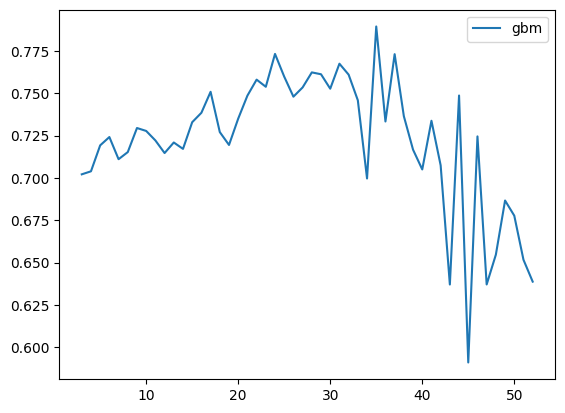

In [76]:
import matplotlib.pyplot as plt
plt.plot(best_scores.keys(), [best_scores[key] for key in best_scores.keys()], label='gbm')
# plt.plot(best_scores_cnet.keys(), [best_scores_cnet[key] for key in best_scores_cnet.keys()], label='elastic-net')
plt.legend()

In [81]:
# write results to pickle file
with open('best_est_gbm_with_chg_h1.pkl', 'wb') as file:
    pickle.dump(best_estimators, file)
with open('best_scores_gbm_with_chg_h1.pkl', 'wb') as file:
    pickle.dump(best_scores, file)

In [80]:
import pickle

In [82]:
with open('best_scores_gbm_with_chg_h1.pkl', 'rb') as file:
    best_scores_gbm = pickle.load(file)

In [83]:
with open('best_est_gbm_with_chg_h1.pkl', 'rb') as file:
    best_estimators_gbm = pickle.load(file)

In [97]:
scores_test = {}
preds_test = {}
for wk in weeks_range:
    X_test = test_sets[wk][feature_cols + cat_cols]
    # X_train = df_train_prep[df_train_prep.index.get_level_values(2) == wk][feature_cols + cat_cols]
    X_test = pd.get_dummies(X_test, columns=['market_name', 'hit_spins_bucket'])
    missing_cols = list(set(best_estimators_gbm[wk].estimator.feature_names_in_) - set(X_test.columns))
    print(missing_cols)
    for col in missing_cols:
        X_test[col] = 0
    # X_train[feature_cols] = StandardScaler().fit_transform(X_train[feature_cols])
    y_test = test_sets[wk][target_cols].to_records(index=False)

    scores_test[wk] = best_estimators_gbm[wk].score(X_test[best_estimators_gbm[wk].estimator.feature_names_in_], y_test)

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['market_name_Denver']
[]
[]
[]
[]
[]
[]
['market_name_Denver']
[]
[]
[]
[]
['market_name_Denver']
[]
[]
[]
[]
[]
['market_name_Dallas']
['market_name_Dallas']
['market_name_Dallas', 'market_name_Chicago']
['market_name_Minneapolis']
['market_name_Chicago', 'market_name_Minneapolis']
['market_name_Raleigh']
['market_name_Denver']
['market_name_Raleigh', 'market_name_Denver']
['market_name_Pittsburgh', 'market_name_Denver']
['market_name_Denver', 'market_name_Salt Lake City']
[]
[]
[]
[]


In [100]:
test_sets[7]

,,,,censoring_flg,spins_to_burnout_curr,med_thumbs_up_rate_prior_unv_prior_26wk_min,std_completed_rate_prior_unv_prior_13wk_mean,mr_stream_count_prior_unv_prior_8wk_min_pct_chg,med_stream_count_prior_unv_prior_8wk_min_pct_chg,mr_completed_rate_prior_unv_prior_26wk_mean,song_market_spins_total_prior_8wk_std,med_completed_rate_prior_unv_prior_8wk_mean_pct_chg,count_artist_format_pop_prior_8wk_mean,...,mr_thumbs_up_rate_prior_unv_prior_26wk_mean,mean_completed_rate_prior_unv_prior_4wk_min_pct_chg,mean_stream_count_prior_unv_prior_26wk_min,mean_thumbs_up_rate_prior_unv_prior_13wk_std,song_format_pop_prior_13wk_std,artist_spins_propn_prior_13wk_max,artist_spins_propn_prior_4wk_max,artist_station_spins_non_on_prior_13wk_max_pct_chg,market_name,hit_spins_bucket
mediabase_id,call_letters,weeks_since_hit,hit_tag_year,,,,,,,,,,,,,,,,,,,,,
2506428,WKST-FM,7.0,2020,True,890.0,0.740156,0.021202,-0.007564,0.002086,0.623905,19.018318,-0.000195,1.400000,...,8.210644e-01,0.000000,38414.250000,0.003186,9.724784,1.000000,1.000000,0.000000,Pittsburgh,"(250.0, 500.0]"
2524291,KKRZ-FM,7.0,2020,True,1800.0,0.826725,0.022893,0.029254,0.000000,0.597808,97.967560,-0.003097,14.875000,...,8.687821e-01,-0.000919,332903.086957,0.003001,2.127355,1.000000,1.000000,0.000000,"Portland, OR","(500.0, 750.0]"
2638062,WKST-FM,7.0,2021,False,2328.0,0.000000,0.231015,0.000000,0.000000,0.857143,24.784788,0.000000,28.125000,...,1.560656e-14,0.000000,117212.583071,0.002032,2.810238,0.870130,0.491803,0.000000,Pittsburgh,"(1000.0, 1250.0]"
2708592,WIOQ-FM,7.0,2021,True,240.0,0.000000,0.231015,0.000000,0.000000,0.857143,3.845220,0.000000,41.428571,...,1.560656e-14,0.000000,117212.583071,0.002032,2.898275,0.772727,0.500000,0.087209,Philadelphia,"(250.0, 500.0]"
2723707,WKFS-FM,7.0,2021,False,2300.0,0.000000,0.231015,0.000000,0.000000,0.857143,11.170753,0.000000,12.750000,...,1.560656e-14,0.000000,117212.583071,0.002032,12.445780,1.000000,1.000000,0.000000,Cincinnati,"(250.0, 500.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2605093,WKSC-FM,7.0,2021,True,895.0,0.000000,0.231015,0.000000,0.000000,0.857143,69.010222,0.000000,10.000000,...,1.560656e-14,0.000000,117212.583071,0.002032,6.506407,1.000000,1.000000,0.000000,Chicago,"(250.0, 500.0]"
2638380,KBKS-FM,7.0,2021,True,417.0,0.000000,0.231015,0.000000,0.000000,0.857143,35.063208,0.000000,14.500000,...,1.560656e-14,0.000000,117212.583071,0.002032,1.450022,1.000000,1.000000,0.000000,Seattle,"(500.0, 750.0]"
2548094,KZZP-FM,7.0,2020,True,41.0,0.898808,0.201035,1.444433,0.107266,0.555787,18.996240,0.002666,13.625000,...,9.033697e-01,0.015193,499.000000,0.003683,1.702939,1.000000,1.000000,0.000000,Phoenix,"(250.0, 500.0]"


In [98]:
scores_test

{3: 0.7410750317172661,
 4: 0.7057593236442946,
 5: 0.7182607712740905,
 6: 0.7367110303959398,
 7: 0.7360469959275971,
 8: 0.7134869065514003,
 9: 0.7317136282117506,
 10: 0.7215890439370215,
 11: 0.7364494499170448,
 12: 0.7561603680949606,
 13: 0.7514448109663779,
 14: 0.7431953878908497,
 15: 0.7171127315798294,
 16: 0.7311521908632466,
 17: 0.7648982030611906,
 18: 0.75602343242615,
 19: 0.7721569132734415,
 20: 0.7517018807125185,
 21: 0.71737460764459,
 22: 0.7717221291531624,
 23: 0.7891467369171032,
 24: 0.7672813406404002,
 25: 0.781028734311454,
 26: 0.8161039678691352,
 27: 0.7769492031310863,
 28: 0.747179070160676,
 29: 0.8015371982874177,
 30: 0.7487421101360395,
 31: 0.7759392241168196,
 32: 0.7434009194248572,
 33: 0.7679563549250813,
 34: 0.7324343585419473,
 35: 0.7882450165393627,
 36: 0.7549912990953112,
 37: 0.7545648973702018,
 38: 0.730781625032502,
 39: 0.744669220725881,
 40: 0.7478068472787741,
 41: 0.8066418364199702,
 42: 0.7266380707978211,
 43: 0.77970699

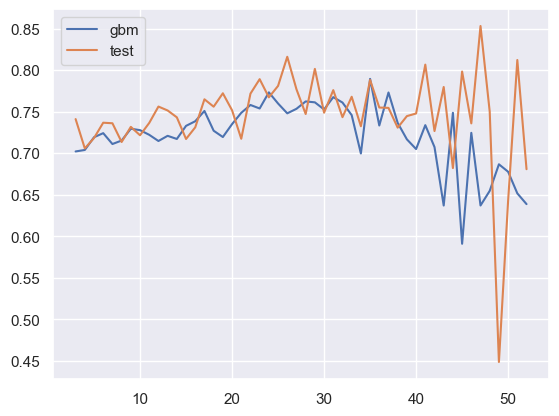

In [99]:
import matplotlib.pyplot as plt

plt.plot(best_scores.keys(), [best_scores[key] for key in best_scores.keys()], label='gbm')
plt.plot(scores_test.keys(), [scores_test[key] for key in scores_test.keys()], label='test')
plt.legend()

#### GBM with time-varying covariates

In [68]:
# define empty dfs
df_train_all = pd.DataFrame()
df_test_all = pd.DataFrame()

# prepare one train/test dataset with all weeks combined
for wk in weeks_range:
    df_train_all = pd.concat([df_train_all, train_sets[wk]])
    df_test_all = pd.concat([df_test_all, test_sets[wk]])

# train a gbm model

In [74]:
df_train_all.reset_index(level=2)

,,,weeks_since_hit,censoring_flg,spins_to_burnout_curr,artist_format_ddl_prior_13wk_max,song_format_ddl_prior_4wk_std,max_completed_rate_prior_unv_prior_13wk_mean,mr_thumbs_up_rate_prior_unv_prior_26wk_mean,med_thumbs_up_rate_prior_unv_prior_4wk_std,mean_completed_rate_prior_unv_prior_13wk_min,max_completed_rate_prior_unv_prior_13wk_min,...,med_thumbs_up_rate_prior_unv_prior_8wk_std,song_station_spins_total_prior_26wk_mean,mr_thumbs_up_rate_prior_unv_prior_4wk_std,song_market_spins_non_on_prior_13wk_mean,artist_format_ddl_prior_13wk_mean,artist_station_spins_am_pm_dr_prior_26wk_max,mr_completed_count_prior_unv_prior_26wk_mean,song_market_spins_am_pm_dr_prior_4wk_mean,market_name,hit_spins_bucket
mediabase_id,call_letters,hit_tag_year,,,,,,,,,,,,,,,,,,,,,
2552475,WHYI-FM,2020,3.0,True,2211.0,10.0,1.000000,0.704868,7.509418e-01,0.002522,0.635440,0.704868,...,0.009877,84.812500,0.009296,278.615385,9.200000,94.0,4.143937e+05,236.50,Miami,"(750.0, 1000.0]"
2531558,KKRZ-FM,2020,3.0,True,1.0,24.0,3.593976,0.673632,7.997083e-01,0.000536,0.637841,0.673632,...,0.000628,19.153846,0.003308,57.769231,17.153846,31.0,3.769485e+06,40.00,"Portland, OR","(2000.0, 2250.0]"
2399249,KSLZ-FM,2020,3.0,True,113.0,19.0,1.414214,0.755534,8.180527e-01,0.003024,0.653539,0.706381,...,0.003432,20.884615,0.030809,49.076923,14.666667,38.0,5.027356e+05,36.75,St. Louis,"(750.0, 1000.0]"
2552475,KDHT-FM,2022,3.0,False,2456.0,18.0,2.516611,0.975610,7.988271e-01,0.000435,0.633617,0.975610,...,0.000459,17.115385,0.027514,16.307692,16.250000,77.0,4.212046e+04,10.50,Denver,"(250.0, 500.0]"
2691407,WHQC-FM,2022,3.0,False,2402.0,15.0,1.500000,1.000000,1.560656e-14,0.000000,0.803461,1.000000,...,0.000000,61.115385,0.000000,119.384615,13.615385,50.0,5.142857e+00,83.25,Charlotte-Gastonia-Rock Hill,"(1250.0, 1500.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2638380,WHTZ-FM,2021,52.0,False,1820.0,22.0,3.774917,1.000000,1.560656e-14,0.000000,0.803461,1.000000,...,0.000000,0.153846,0.000000,0.307692,16.333333,2.0,5.142857e+00,0.00,New York,"(250.0, 500.0]"
2687342,WWPW-FM,2021,52.0,False,2348.0,16.0,0.707107,1.000000,1.560656e-14,0.000000,0.803461,1.000000,...,0.000000,0.115385,0.000000,36.461538,12.000000,1.0,5.142857e+00,33.25,Atlanta,"(500.0, 750.0]"
2653276,KKRZ-FM,2021,52.0,False,2133.0,18.0,4.041452,1.000000,1.560656e-14,0.000000,0.803461,1.000000,...,0.000000,0.000000,0.000000,0.153846,16.500000,66.0,5.142857e+00,0.50,"Portland, OR","(1000.0, 1250.0]"


#### Variable Importance

In [81]:
from shap import Explainer
explainers = {}
shaps = {}
test_scores_gbm = {}
for wk in [26]:
    X_train = train_sets[wk][feature_cols + cat_cols]
    # X_train = df_train_prep[df_train_prep.index.get_level_values(2) == wk][feature_cols + cat_cols]
    X_train = pd.get_dummies(X_train, columns=['market_name', 'hit_spins_bucket'])
    # X_train[feature_cols] = StandardScaler().fit_transform(X_train[feature_cols])
    y_train = train_sets[wk][target_cols].to_records(index=False)

    # X_test = test_sets[wk][feature_cols + cat_cols]
    # X_test = pd.get_dummies(X_test, columns=['market_name', 'hit_spins_bucket'])
    # y_test = test_sets[wk][target_cols].to_records(index=False)
    #
    sv = best_estimators_gbm[wk]
    #
    # print(wk)
    # test_scores_gbm[wk] = sv.score(X_test[X_train.columns], y_test)
    feature_names = sv.estimator.feature_names_in_
    # print(feature_names)
    if wk == 26:
        explainers[wk] = Explainer(sv.predict, X_train[feature_names], feature_names=feature_names, max_evals=5000)
        shaps[wk] = explainers[wk](X_train)

Permutation explainer: 505it [51:39,  6.16s/it]                         


In [82]:
shaps

{26: .values =
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])
 
 .base_values =
 array([-0.03088085, -0.03088085, -0.03088085, -0.03088085, -0.03088085,
        -0.03088085, -0.03088085, -0.03088085, -0.03088085, -0.03088085,
        -0.03088085, -0.03088085, -0.03088085, -0.03088085, -0.03088085,
        -0.03088085, -0.03088085, -0.03088085, -0.03088085, -0.03088085,
        -0.03088085, -0.03088085, -0.03088085, -0.03088085, -0.03088085,
        -0.03088085, -0.03088085, -0.03088085, -0.03088085, -0.03088085,
        -0.03088085, -0.03088085, -0.03088085, -0.03088085, -0.03088085,
        -0.03088085, -0.03088085, -0.03088085, -0.03088085, -0.03088085,
        -0.03088085, -0.03088085, -0.03088085, -0.03088085, -0.03088085,
        -0.03088085, -0.03088085, -0.03088085, -0.03088085, -0

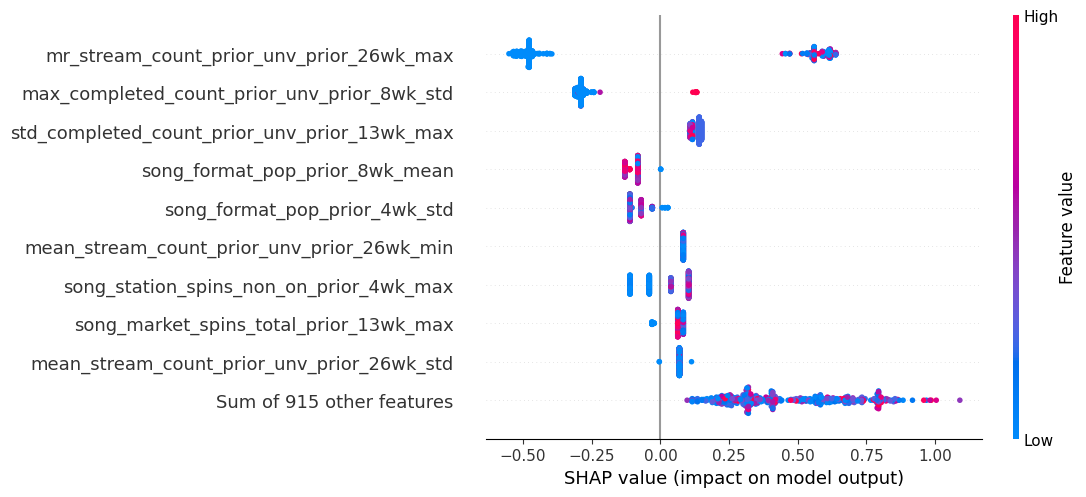

In [83]:
from shap.plots import beeswarm
beeswarm(shaps[26])

In [99]:
shaps[26][0]

.values =
array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  9.68868393e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -3.49695467e-04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -3.01655732e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.00792257e-02,  0.00000000e+00,  0.00000000e+00, -1.47526592e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000

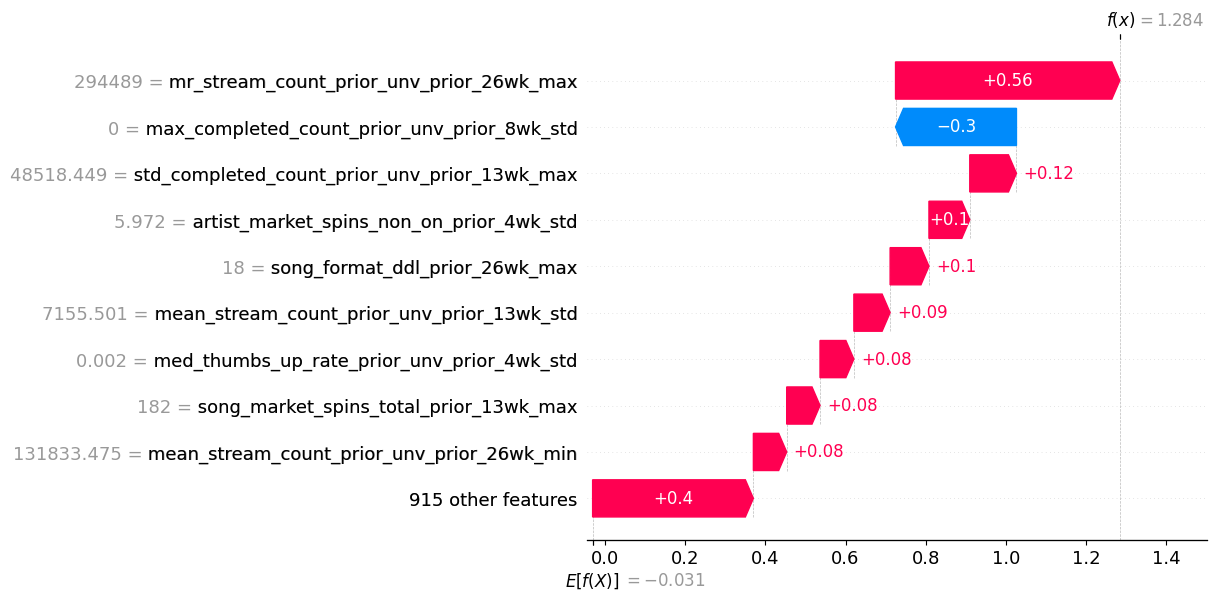

In [98]:
from shap.plots import waterfall
waterfall(shaps[26][0], max_display=10)

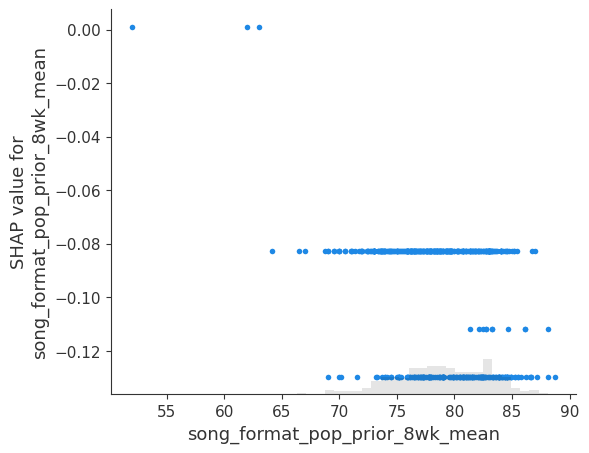

In [97]:
from shap.plots import scatter
scatter(shaps[26][:,"song_format_pop_prior_8wk_mean"])

In [90]:
shaps[26].data

array([[1.48461538e+01, 1.04700000e+03, 1.19567250e+05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.73333333e+01, 2.27000000e+02, 1.52180000e+04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.42857143e+00, 1.98300000e+03, 1.64000000e+02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.26923077e+01, 4.68000000e+02, 1.64000000e+02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.50000000e+01, 3.64000000e+02, 1.28671429e+05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.75000000e+00, 2.38000000e+02, 1.64000000e+02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [91]:
X_train

,,,,song_station_ddl_prior_26wk_mean,song_format_spins_am_pm_dr_prior_4wk_max,med_completed_count_prior_unv_prior_8wk_mean,song_format_ddl_prior_26wk_max,song_station_ddl_prior_4wk_std,song_station_spins_am_pm_dr_prior_4wk_max,song_station_spins_am_pm_dr_prior_8wk_min,count_song_format_pop_prior_8wk_min,artist_market_spins_am_pm_dr_prior_4wk_max,artist_market_spins_am_pm_dr_prior_4wk_std,...,"hit_spins_bucket_(1250.0, 1500.0]","hit_spins_bucket_(1500.0, 1750.0]","hit_spins_bucket_(1750.0, 2000.0]","hit_spins_bucket_(2000.0, 2250.0]","hit_spins_bucket_(2250.0, 2500.0]","hit_spins_bucket_(2500.0, 2750.0]","hit_spins_bucket_(2750.0, 3000.0]","hit_spins_bucket_(3000.0, 3250.0]","hit_spins_bucket_(3250.0, 3500.0]","hit_spins_bucket_(3500.0, 3750.0]"
mediabase_id,call_letters,weeks_since_hit,hit_tag_year,,,,,,,,,,,,,,,,,,,,,
2553815,WWPW-FM,26.0,2020,14.846154,1047.0,119567.250000,18.0,1.414214e+00,15.0,6.0,3.0,15.0,4.031129,...,0,0,0,0,0,0,0,0,0,0
1086587,KYLD-FM,26.0,2022,17.333333,227.0,15218.000000,29.0,6.363961e+00,0.0,0.0,1.0,11.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
2720292,KHKS-FM,26.0,2021,9.428571,1983.0,164.000000,15.0,9.192388e+00,18.0,0.0,1.0,236.0,9.105859,...,0,0,0,0,0,0,0,0,0,0
2553815,KKRZ-FM,26.0,2020,14.600000,2063.0,113256.750000,18.0,7.778175e+00,1.0,1.0,3.0,1.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
2722189,WHYI-FM,26.0,2021,14.888889,2808.0,164.000000,19.0,3.535534e+00,16.0,9.0,2.0,44.0,2.500000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2720314,KHKS-FM,26.0,2022,14.800000,1140.0,164.000000,24.0,1.192093e-07,27.0,12.0,6.0,106.0,2.943920,...,0,0,1,0,0,0,0,0,0,0
2597601,WKQI-FM,26.0,2021,13.166667,2584.0,164.000000,16.0,2.121320e+00,25.0,1.0,1.0,98.0,18.876794,...,0,0,0,0,0,0,0,0,0,0
2645722,WFLZ-FM,26.0,2021,12.692308,468.0,164.000000,17.0,2.828427e+00,33.0,8.0,1.0,56.0,11.328430,...,0,0,0,0,0,0,0,0,0,0


In [77]:
# collect all features
all_features_len = len(feature_cols) + len(pd.get_dummies(df_train_prep[['market_name', 'hit_spins_bucket']]).columns)
all_features = feature_cols + list(pd.get_dummies(df_train_prep[['market_name', 'hit_spins_bucket']]).columns)

In [84]:
feature_imps = {}
for wk in best_estimators_gbm.keys():
    feature_names = best_estimators_gbm[wk].estimator_.feature_names_in_
    feature_imps[wk] = pd.DataFrame(best_estimators_gbm[wk].estimator_.feature_importances_, index=feature_names,
             columns=['feature_importance_week']).sort_values(by=['feature_importance_week'], ascending=False)

In [85]:
df_imps = feature_imps[13]
importances = df_imps[df_imps['feature_importance_week'] > 0][:7]
features = list(df_imps[df_imps['feature_importance_week'] > 0][:7].index)
indices = np.arange(0,16)

In [87]:
import re
freq_imps = {key: pd.unique([re.sub('[1-9]{1}wk_', '', re.sub('[1-9]{2}wk_', '', col)) for col in list(feature_imps[key][:10].index)]) for key in feature_imps}

In [88]:
freq_imps_dict = {}

for key in freq_imps.keys():
    for col in freq_imps[key]:
        if col in freq_imps_dict:
            freq_imps_dict[col] = freq_imps_dict[col] + 1
        else:
            freq_imps_dict[col] = 1

In [89]:
freq_dict = dict(sorted(freq_imps_dict.items(), key=lambda item: item[1], reverse=True))
df_frq_dict = pd.DataFrame([(i, j)  for i, j in freq_dict.items()],
                   columns=['keys','values'])

In [90]:
df_frq_dict['perc'] = df_frq_dict['values']/49

In [91]:
df_frq_dict

,keys,values,perc
0,song_station_ddl_prior_max,50,1.020408
1,song_station_ddl_prior_mean,32,0.653061
2,song_format_ddl_prior_min,22,0.448980
3,song_format_ddl_prior_mean,19,0.387755
4,song_format_ddl_prior_std,19,0.387755
...,...,...,...
81,artist_station_spins_total_prior_min_pct_chg,1,0.020408
82,mr_completed_count_prior_unv_prior_max_pct_chg,1,0.020408
83,max_completed_count_prior_unv_prior_mean_pct_chg,1,0.020408
84,artist_format_spins_am_pm_dr_prior_max_pct_chg,1,0.020408


In [94]:
importances

,feature_importance_week
song_station_ddl_prior_13wk_max,0.390176
song_station_spins_non_on_prior_4wk_mean,0.092250
artist_station_spins_am_pm_dr_prior_8wk_min,0.076347
song_station_ddl_prior_8wk_max,0.068780
song_station_ddl_prior_13wk_mean,0.043209
song_format_spins_am_pm_dr_prior_4wk_min,0.035077
song_market_spins_am_pm_dr_prior_4wk_max,0.029833


In [85]:
np.arange(5.0, 0, - 0.5)

array([5. , 4.5, 4. , 3.5, 3. , 2.5, 2. , 1.5, 1. , 0.5])

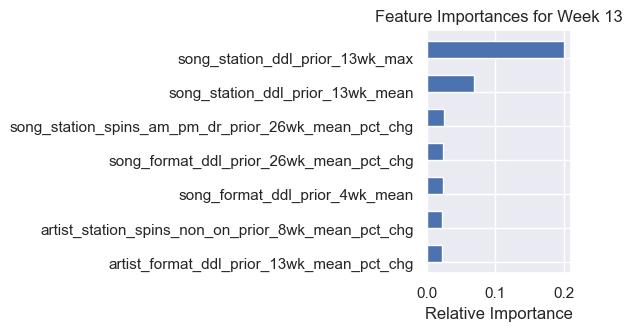

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
plt.title('Feature Importances for Week 13')
fig = plt.gcf()
fig.set_size_inches((6,8))
plt.barh(np.arange(0.7, 0, - 0.1), importances['feature_importance_week'], height=0.05, color='b', align='edge')
plt.yticks(np.arange(0.7, 0, - 0.1), features)
plt.xlabel('Relative Importance')
plt.tight_layout()
ax = plt.gca()
ax.set_aspect(0.5)
plt.tight_layout()
plt.savefig('feature_imp_surv.jpeg', format='jpeg', dpi=300)

In [69]:
feature_imps_markets = {feat: feature_imps[feat][feature_imps[feat].index.map(lambda s: s.startswith('market_name_'))][:10] for feat in feature_imps}

In [70]:
feature_imps_markets

{3:                             feature_importance_week
 market_name_Pittsburgh                     0.007480
 market_name_Atlanta                        0.003951
 market_name_Nashville                      0.003471
 market_name_Orlando                        0.002857
 market_name_San Francisco                  0.000000
 market_name_Seattle                        0.000000
 market_name_St. Louis                      0.000000
 market_name_Tampa                          0.000000
 market_name_Washington, DC                 0.000000
 market_name_Salt Lake City                 0.000000,
 4:                             feature_importance_week
 market_name_Atlanta                        0.010437
 market_name_Pittsburgh                     0.003184
 market_name_Nashville                      0.001049
 market_name_Minneapolis                    0.000902
 market_name_New York                       0.000770
 market_name_Columbus, OH                   0.000615
 market_name_Raleigh                   

In [149]:
feature_imps[26]

,feature_importance_week
song_station_ddl_prior_26wk_max,0.050022
song_station_ddl_prior_13wk_max,0.037037
count_song_format_pop_prior_4wk_std,0.026223
song_station_spins_total_prior_4wk_max,0.023987
song_station_spins_total_prior_13wk_mean,0.022314
...,...
artist_format_spins_total_prior_26wk_min,0.000000
artist_format_pop_prior_4wk_max,0.000000
max_thumbs_up_rate_prior_unv_prior_8wk_mean,0.000000
std_thumbs_up_rate_prior_unv_prior_4wk_std,0.000000


In [103]:
df_hits_tracker.groupby(['hit_spins_bucket_curr', 'censoring_flg'])['spins_to_burnout_from_hit'].describe()

count         mean         std     min  \
hit_spins_bucket_curr censoring_flg                                            
early                 False             3.0  3007.000000  460.348781  2518.0   
                      True             80.0  1183.475000  460.559428   183.0   
mid                   False            16.0  2882.375000  278.648135  2514.0   
                      True            643.0  1099.024883  500.014847     4.0   
late                  False            18.0  2936.833333  365.728001  2502.0   
                      True           1759.0   773.322911  523.921724     8.0   

                                         25%     50%      75%     max  
hit_spins_bucket_curr censoring_flg                                    
early                 False          2794.50  3071.0  3251.50  3432.0  
                      True            809.00  1235.5  1523.00  2155.0  
mid                   False          2652.00  2915.5  2993.75  3518.0  
                      True            743.00  1063.0  1410.50  2437.0  
late                  False          2579.75  2942.0  3138.50  3652.0  
                      True            359.50   681.0  1079.50  2481.0

#### Risk Scores and Survival Function

In [23]:
risk_scores_gbm_train=pd.DataFrame()
risk_scores_gbm_test=pd.DataFrame()
# surv_fn_gbm = {}
# for wk in weeks_range:
for wk in weeks_range:
    X_train = train_sets[wk][feature_cols + cat_cols]
    X_train = pd.get_dummies(X_train, columns=['market_name', 'hit_spins_bucket'])
    # X_train[feature_cols] = StandardScaler().fit_transform(X_train[feature_cols])
    y_train = train_sets[wk][target_cols]
    feature_names = best_estimators_gbm[wk].estimator.feature_names_in_
    missing_cols = list(set(feature_names) - set(X_train.columns))
    print(wk)
    print(missing_cols)
    X_train[missing_cols] = 0
    df_temp = pd.concat([y_train, pd.DataFrame(best_estimators_gbm[wk].predict(X_train[feature_names]), index=X_train.index, columns=['predicted_risk_score'])] ,axis=1).assign(**{'week': wk})
    risk_scores_gbm_train = pd.concat([risk_scores_gbm_train, df_temp])
    # surv_fn_gbm[wk] = best_estimators_gbm[wk].predict_survival_function(X_train[feature_names])

3
[]
4
[]
5
[]
6
[]
7
[]
8
[]
9
[]
10
[]
11
[]
12
[]
13
[]
14
[]
15
[]
16
[]
17
[]
18
[]
19
[]
20
[]
21
[]
22
[]
23
[]
24
[]
25
[]
26
[]
27
[]
28
[]
29
[]
30
[]
31
[]
32
[]
33
[]
34
[]
35
[]
36
[]
37
[]
38
[]
39
[]
40
[]
41
[]
42
[]
43
[]
44
[]
45
[]
46
[]
47
[]
48
[]
49
[]
50
[]
51
[]
52
[]


In [24]:
test_risk_scores = risk_scores_gbm_train[risk_scores_gbm_train['week']==8].sort_values(by=['predicted_risk_score'])

In [25]:
risk_scores_gbm_train = risk_scores_gbm_train.assign(**{'predcited_risk_score_quintile' : risk_scores_gbm_train.groupby(['weeks_since_hit']).apply(lambda x: pd.qcut(x['predicted_risk_score'], q=5, duplicates='drop', labels=False)).droplevel(0)})

In [26]:
risk_scores_gbm_train['actual_quintile'] = 1
risk_scores_gbm_train.loc[(risk_scores_gbm_train['censoring_flg'] == False), 'actual_quintile'] = 0
risk_scores_gbm_train.loc[(risk_scores_gbm_train['spins_to_burnout_curr'] < 100) , 'actual_quintile'] = 2

In [27]:
risk_scores_gbm_train['predcited_risk_score_quintile_n'] = risk_scores_gbm_train['predcited_risk_score_quintile']

In [28]:
risk_scores_gbm_train.loc[((risk_scores_gbm_train['predcited_risk_score_quintile'] < 4) & (risk_scores_gbm_train['predcited_risk_score_quintile'] > 0)), 'predcited_risk_score_quintile_n'] = 1

In [29]:
risk_scores_gbm_train.loc[(risk_scores_gbm_train['predcited_risk_score_quintile'] == 4), 'predcited_risk_score_quintile_n'] = 2

In [225]:
risk_scores_gbm_train

,,,,censoring_flg,spins_to_burnout_curr,predicted_risk_score,week,predcited_risk_score_quintile,actual_quintile,predcited_risk_score_quintile_n
mediabase_id,call_letters,weeks_since_hit,hit_tag_year,,,,,,,
2582475,KDHT-FM,3.0,2022,False,2359.0,-0.697761,3,1,0,1
2708592,WDCG-FM,3.0,2021,False,2515.0,-0.226783,3,2,0,1
2620824,KDWB-FM,3.0,2020,True,842.0,-0.144712,3,2,1,1
2720292,KHTS-FM,3.0,2022,True,1337.0,-0.830160,3,0,1,0
2578378,KHKS-FM,3.0,2020,True,63.0,1.470365,3,4,1,2
...,...,...,...,...,...,...,...,...,...,...
2638380,WHTZ-FM,52.0,2021,False,1820.0,-0.006245,52,0,0,0
2697903,WWPW-FM,52.0,2021,False,638.0,0.004916,52,2,0,1
2582475,WHYI-FM,52.0,2021,False,1510.0,0.017074,52,3,0,1


In [66]:
risk_scores_gbm_train = risk_scores_gbm_train.assign(**{'spins_to_burnout_curr_quintile' : risk_scores_gbm_train.groupby(['weeks_since_hit']).apply(lambda x: pd.qcut(x['spins_to_burnout_curr'], q=5, duplicates='drop', labels=False)).droplevel(0)})

In [35]:
import matplotlib.pyplot as plt

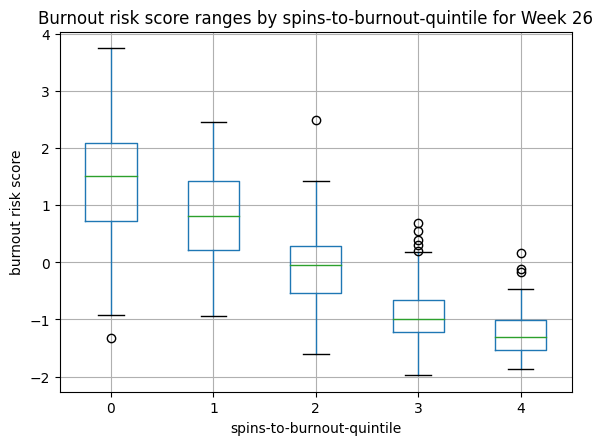

In [36]:
risk_scores_gbm_train[risk_scores_gbm_train['week'] == 26].boxplot(['predicted_risk_score'], by=['spins_to_burnout_curr_quintile'])
plt.ylabel('burnout risk score')
plt.xlabel('spins-to-burnout-quintile')
plt.title('Burnout risk score ranges by spins-to-burnout-quintile for Week 26')
fig = plt.gcf()
fig.suptitle('')
plt.savefig('burn_risk_score.jpeg', format='jpeg', dpi=300)

In [237]:
from sklearn.metrics import confusion_matrix
mask = risk_scores_gbm_train['week']==13
confusion_matrix(y_true=risk_scores_gbm_train.loc[mask, 'actual_quintile'], y_pred=risk_scores_gbm_train.loc[mask, 'predcited_risk_score_quintile_n'], labels=[0, 1, 2])

array([[150, 208,  13],
       [  8, 231,  77],
       [  6,  50,  73]])

In [210]:
risk_scores_gbm_train.loc[mask, 'actual_quintile']

mediabase_id  call_letters  weeks_since_hit  hit_tag_year
2750191       KKRZ-FM       6.0              2022            4
2671521       WXKS-FM       6.0              2021            2
2672451       WRVW-FM       6.0              2021            2
2834725       WHTZ-FM       6.0              2022            2
2591543       WKST-FM       6.0              2020            2
                                                            ..
2708592       WKSC-FM       6.0              2021            2
2542279       KDWB-FM       6.0              2020            2
2744465       KBKS-FM       6.0              2022            2
2524291       WXXL-FM       6.0              2020            2
2687228       KYLD-FM       6.0              2021            4
Name: actual_quintile, Length: 1033, dtype: int64

In [193]:
risk_scores_gbm_train.groupby(['weeks_since_hit']).apply(lambda x: pd.qcut(x['predicted_risk_score'], q=5, duplicates='drop', labels=False)).droplevel(0)

mediabase_id  call_letters  weeks_since_hit  hit_tag_year
2582475       KDHT-FM       3.0              2022            1
2708592       WDCG-FM       3.0              2021            2
2620824       KDWB-FM       3.0              2020            2
2720292       KHTS-FM       3.0              2022            0
2578378       KHKS-FM       3.0              2020            4
                                                            ..
2638380       WHTZ-FM       52.0             2021            0
2697903       WWPW-FM       52.0             2021            2
2582475       WHYI-FM       52.0             2021            3
2625043       WFLZ-FM       52.0             2021            1
2502821       KDWB-FM       52.0             2020            0
Name: predicted_risk_score, Length: 28106, dtype: int64

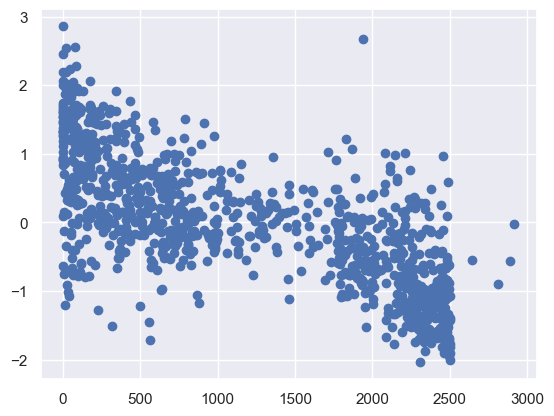

In [172]:
import matplotlib.pyplot as plt
plt.scatter(test_risk_scores['spins_to_burnout_curr'], test_risk_scores['predicted_risk_score'])

In [333]:
risk_scores_gbm_train[(risk_scores_gbm_train['week'] == 26) & (risk_scores_gbm_train.index.get_level_values(1) == 'KIIS-FM')]

,,,,censoring_flg,spins_to_burnout_curr,predicted_risk_score,week,predcited_risk_score_quintile,actual_quintile,predcited_risk_score_quintile_n,spins_to_burnout_curr_quintile
mediabase_id,call_letters,weeks_since_hit,hit_tag_year,,,,,,,,
2710332,KIIS-FM,26.0,2021,False,2237.0,-0.938894,26,1,0,1,3
2505085,KIIS-FM,26.0,2020,False,1199.0,-0.035873,26,2,0,1,2
2552613,KIIS-FM,26.0,2020,True,149.0,2.174482,26,4,1,2,0
2798183,KIIS-FM,26.0,2022,True,1301.0,0.607021,26,3,1,1,2
2546157,KIIS-FM,26.0,2020,False,1960.0,-1.086304,26,1,0,1,3
2554446,KIIS-FM,26.0,2020,False,939.0,0.815524,26,3,0,1,1
2550239,KIIS-FM,26.0,2020,True,67.0,1.710423,26,4,2,2,0
2398331,KIIS-FM,26.0,2020,False,2332.0,-1.015808,26,1,0,1,4
2541634,KIIS-FM,26.0,2020,False,2432.0,-1.686730,26,0,0,0,4


In [346]:
# Non-Burnout Instance
mask = (risk_scores_gbm_train.index.get_level_values(0) == 2256903) & (risk_scores_gbm_train.index.get_level_values(1) == 'KIIS-FM')
df_burn_example = risk_scores_gbm_train.loc[mask]

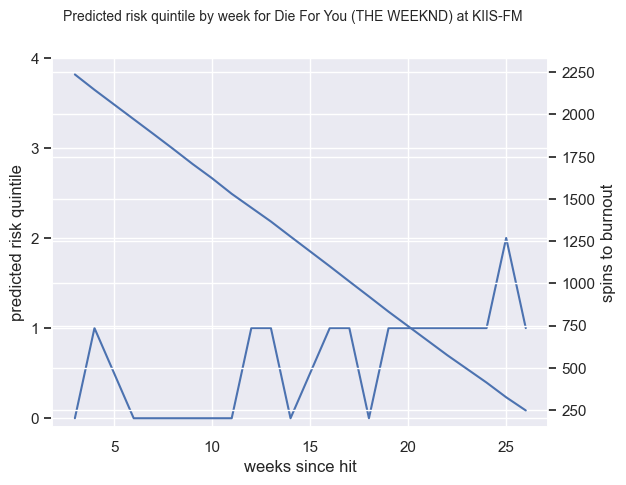

In [397]:
fig, ax = plt.subplots()
ax.plot(df_burn_example['week'], df_burn_example['predcited_risk_score_quintile'])
ax.set_yticks([0,1,2,3,4])
ax.set_xlabel('weeks since hit')
ax.set_ylabel('predicted risk quintile')
secax=ax.twinx()
secax.plot(df_burn_example['week'], df_burn_example['spins_to_burnout_curr'])
secax.set_ylabel('spins to burnout')
plt.suptitle('Predicted risk quintile by week for Die For You (THE WEEKND) at KIIS-FM', fontsize='small')
plt.savefig('pred_risk_quintile.jpeg', format='jpeg', dpi=300)

#### risk quintile for burnout instance

In [ ]:
mask = (df_features['mediabase_id'] == 2552613) & (df_features['call_letters'] == 'KIIS-FM') & (df_features['weeks_since_hit'] >= 3) & (df_features['weeks_since_hit'] <= 28)
df_burn_example_with = df_features.loc[mask][['weeks_since_hit', 'song_station_ddl', 'song_station_ddl_prior_1wk_mean']]

In [421]:
df_burn_example

censoring_flg  \
mediabase_id call_letters weeks_since_hit hit_tag_year                  
2552613      KIIS-FM      3.0             2020                   True   
                          7.0             2020                   True   
                          9.0             2020                   True   
                          11.0            2020                   True   
                          12.0            2020                   True   
                          13.0            2020                   True   
                          15.0            2020                   True   
                          16.0            2020                   True   
                          17.0            2020                   True   
                          18.0            2020                   True   
                          19.0            2020                   True   
                          21.0            2020                   True   
                          22.0            2020                   True   
                          23.0            2020                   True   
                          24.0            2020                   True   
                          26.0            2020                   True   
                          27.0            2020                   True   
                          28.0            2020                   True   

                                                        spins_to_burnout_curr  \
mediabase_id call_letters weeks_since_hit hit_tag_year                          
2552613      KIIS-FM      3.0             2020                         1585.0   
                          7.0             2020                         1239.0   
                          9.0             2020                         1092.0   
                          11.0            2020                         1011.0   
                          12.0            2020                          969.0   
                          13.0            2020                          910.0   
                          15.0            2020                          740.0   
                          16.0            2020                          681.0   
                          17.0            2020                          614.0   
                          18.0            2020                          526.0   
                          19.0            2020                          469.0   
                          21.0            2020                          385.0   
                          22.0            2020                          375.0   
                          23.0            2020                          348.0   
                          24.0            2020                          305.0   
                          26.0            2020                          149.0   
                          27.0            2020                           63.0   
                          28.0            2020                            0.0   

                                                        predicted_risk_score  \
mediabase_id call_letters weeks_since_hit hit_tag_year                         
2552613      KIIS-FM      3.0             2020                     -0.439660   
                          7.0             2020                     -0.177150   
                          9.0             2020                     -0.085950   
                          11.0            2020                      0.170819   
                          12.0            2020                      0.177251   
                          13.0            2020                      0.094524   
                          15.0            2020                      0.363582   
                          16.0            2020                      1.026711   
                          17.0            2020                      0.967379   
                          18.0            2020                      1.643419   
              

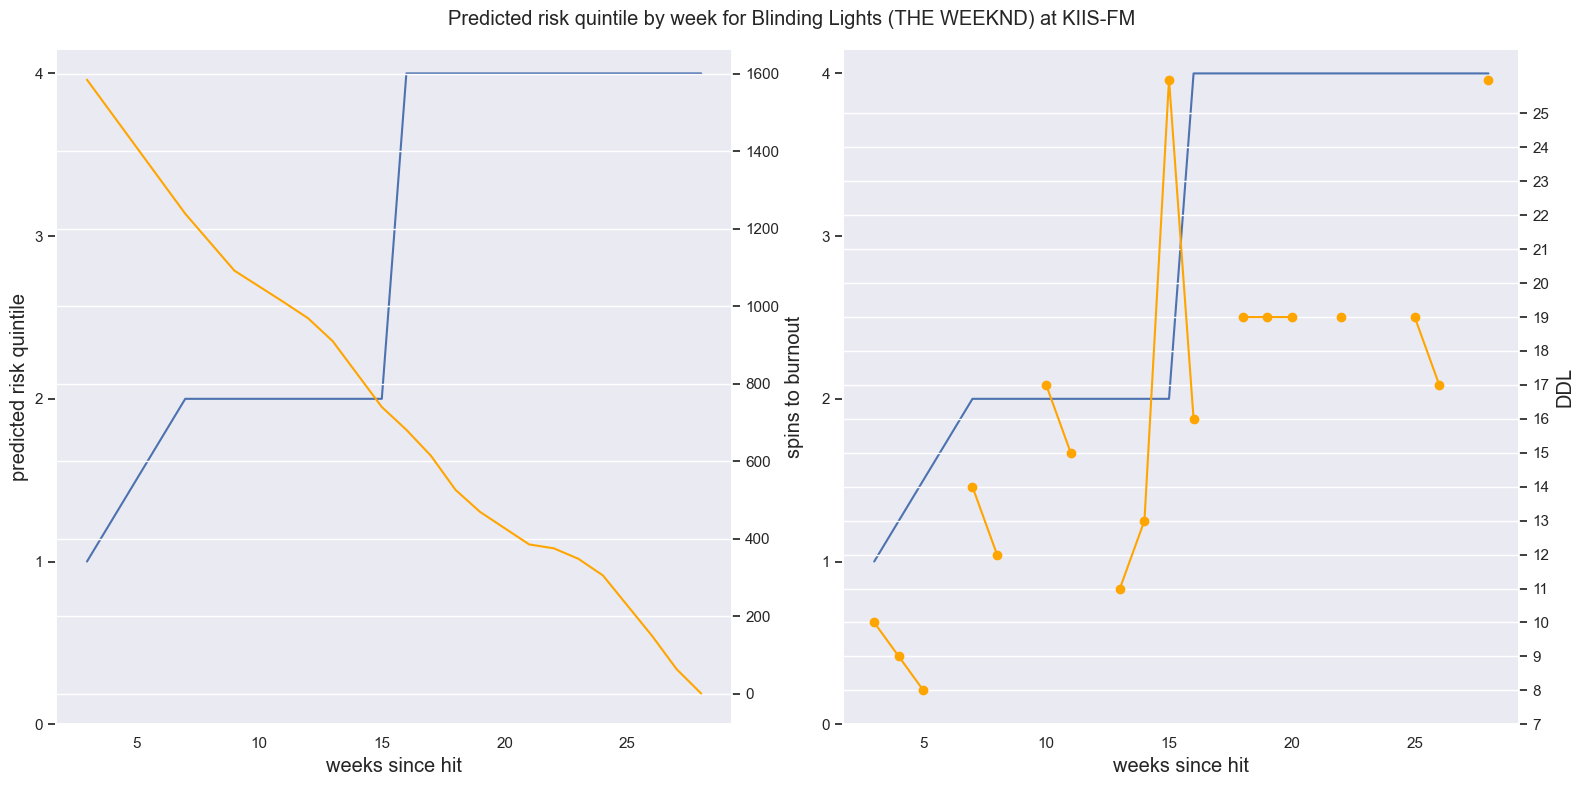

In [449]:
mask = (risk_scores_gbm_train.index.get_level_values(0) == 2552613) & (
            risk_scores_gbm_train.index.get_level_values(1) == 'KIIS-FM')
df_burn_example = risk_scores_gbm_train.loc[mask]
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
fig.set_size_inches(16,8)
ax1.plot(df_burn_example['week'], df_burn_example['predcited_risk_score_quintile'])
ax1.set_yticks([0, 1, 2, 3, 4])
ax1.set_xlabel('weeks since hit', fontsize='large')
ax1.set_ylabel('predicted risk quintile', fontsize='large')
secax = ax1.twinx()
secax.plot(df_burn_example['week'], df_burn_example['spins_to_burnout_curr'], c='orange')
secax.set_ylabel('spins to burnout', fontsize='large')

ax2.plot(df_burn_example['week'], df_burn_example['predcited_risk_score_quintile'])
ax2.set_yticks([0, 1, 2, 3, 4])
ax2.set_xlabel('weeks since hit', fontsize='large')
secax2 = ax2.twinx()
secax2.plot(df_burn_example_with['weeks_since_hit'], df_burn_example_with['song_station_ddl'], marker='o', c='orange')
secax2.set_ylabel('DDL', fontsize='large')
secax2.set_yticks(np.arange(7,26))
plt.suptitle('Predicted risk quintile by week for Blinding Lights (THE WEEKND) at KIIS-FM', fontsize='large')
plt.tight_layout()
ax1.grid()
ax2.grid()
plt.savefig('pred_risk_quintile_with_burn.jpeg', format='jpeg', dpi=300)

#### predicted survival function

In [350]:
surv_fn_gbm = {}
# surv_fn_gbm = {}
# for wk in weeks_range:
for wk in weeks_range:
    X_train = train_sets[wk][feature_cols + cat_cols]
    X_train = pd.get_dummies(X_train, columns=['market_name', 'hit_spins_bucket'])
    # X_train[feature_cols] = StandardScaler().fit_transform(X_train[feature_cols])
    y_train = train_sets[wk][target_cols]
    feature_names = best_estimators_gbm[wk].estimator.feature_names_in_
    missing_cols = list(set(feature_names) - set(X_train.columns))
    print(wk)
    print(missing_cols)
    X_train[missing_cols] = 0
    mask = (X_train.index.get_level_values(0) == 2256903) & (X_train.index.get_level_values(1) == 'KIIS-FM')
    if X_train.loc[mask][feature_names].shape[0] > 0:
        surv_fn_gbm[wk] = best_estimators_gbm[wk].predict_survival_function(X_train.loc[mask][feature_names])

3
[]
4
[]
5
[]
6
[]
7
[]
8
[]
9
[]
10
[]
11
[]
12
[]
13
[]
14
[]
15
[]
16
[]
17
[]
18
[]
19
[]
20
[]
21
[]
22
[]
23
[]
24
[]
25
[]
26
[]
27
[]
28
[]
29
[]
30
[]
31
[]
32
[]
33
[]
34
[]
35
[]
36
[]
37
[]
38
[]
39
[]
40
[]
41
[]
42
[]
43
[]
44
[]
45
[]
46
[]
47
[]
48
['market_name_Denver']
49
[]
50
[]
51
[]
52
[]


In [351]:
surv_fn_gbm

{3: array([StepFunction(x=array([0.000e+00, 1.000e+00, 2.000e+00, 4.000e+00, 5.000e+00, 7.000e+00,
               1.200e+01, 1.400e+01, 1.700e+01, 1.900e+01, 2.200e+01, 2.400e+01,
               2.500e+01, 2.600e+01, 2.800e+01, 2.900e+01, 3.000e+01, 3.100e+01,
               3.200e+01, 3.700e+01, 3.800e+01, 3.900e+01, 4.100e+01, 4.200e+01,
               4.400e+01, 4.500e+01, 4.600e+01, 4.700e+01, 4.800e+01, 4.900e+01,
               5.000e+01, 5.300e+01, 5.700e+01, 5.800e+01, 6.000e+01, 6.100e+01,
               6.200e+01, 6.300e+01, 6.400e+01, 6.900e+01, 7.000e+01, 7.200e+01,
               7.400e+01, 7.600e+01, 8.300e+01, 8.600e+01, 8.700e+01, 8.800e+01,
               8.900e+01, 9.100e+01, 9.200e+01, 9.300e+01, 9.400e+01, 9.500e+01,
               9.600e+01, 9.700e+01, 9.800e+01, 9.900e+01, 1.000e+02, 1.030e+02,
               1.060e+02, 1.070e+02, 1.100e+02, 1.120e+02, 1.130e+02, 1.160e+02,
               1.180e+02, 1.190e+02, 1.200e+02, 1.260e+02, 1.280e+02, 1.300e+02,
          

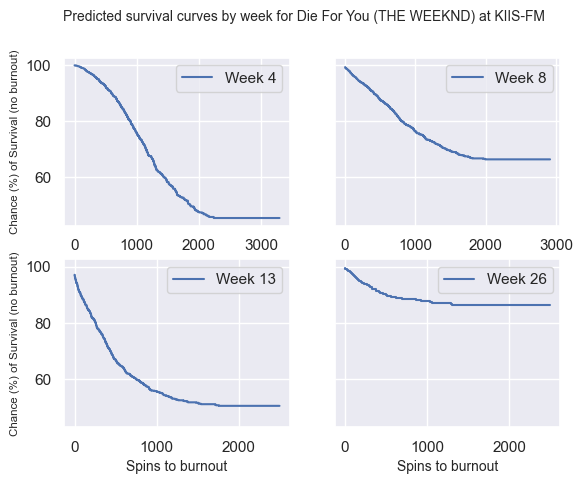

In [407]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, sharey=True)
ax1.step(surv_fn_gbm[4][0].x, 100*surv_fn_gbm[4][0].y , label='Week 4')
ax2.step(surv_fn_gbm[8][0].x, 100*surv_fn_gbm[8][0].y , label='Week 8')
ax3.step(surv_fn_gbm[13][0].x, 100*surv_fn_gbm[13][0].y , label='Week 13')
ax4.step(surv_fn_gbm[26][0].x, 100*surv_fn_gbm[26][0].y , label='Week 26')
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax1.set_ylabel('Chance (%) of Survival (no burnout)', fontsize='x-small')
ax3.set_ylabel('Chance (%) of Survival (no burnout)', fontsize='x-small')
ax3.set_xlabel('Spins to burnout', fontsize='small')
ax4.set_xlabel('Spins to burnout', fontsize='small')

plt.suptitle('Predicted survival curves by week for Die For You (THE WEEKND) at KIIS-FM', fontsize='small')
plt.savefig('pred_surv_curves.jpeg', format='jpeg', dpi=300)

#### Error Analysis

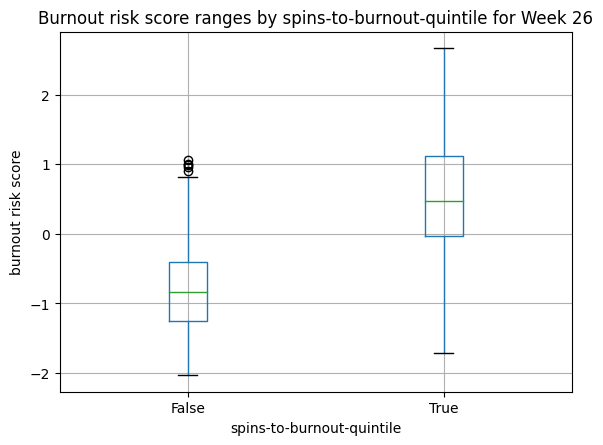

In [58]:
risk_scores_gbm_train[risk_scores_gbm_train['week'] == 8].boxplot(['predicted_risk_score'], by=['censoring_flg'])
plt.ylabel('burnout risk score')
plt.xlabel('spins-to-burnout-quintile')
plt.title('Burnout risk score ranges by spins-to-burnout-quintile for Week 26')
fig = plt.gcf()
fig.suptitle('')
plt.savefig('burn_risk_score.jpeg', format='jpeg', dpi=300)

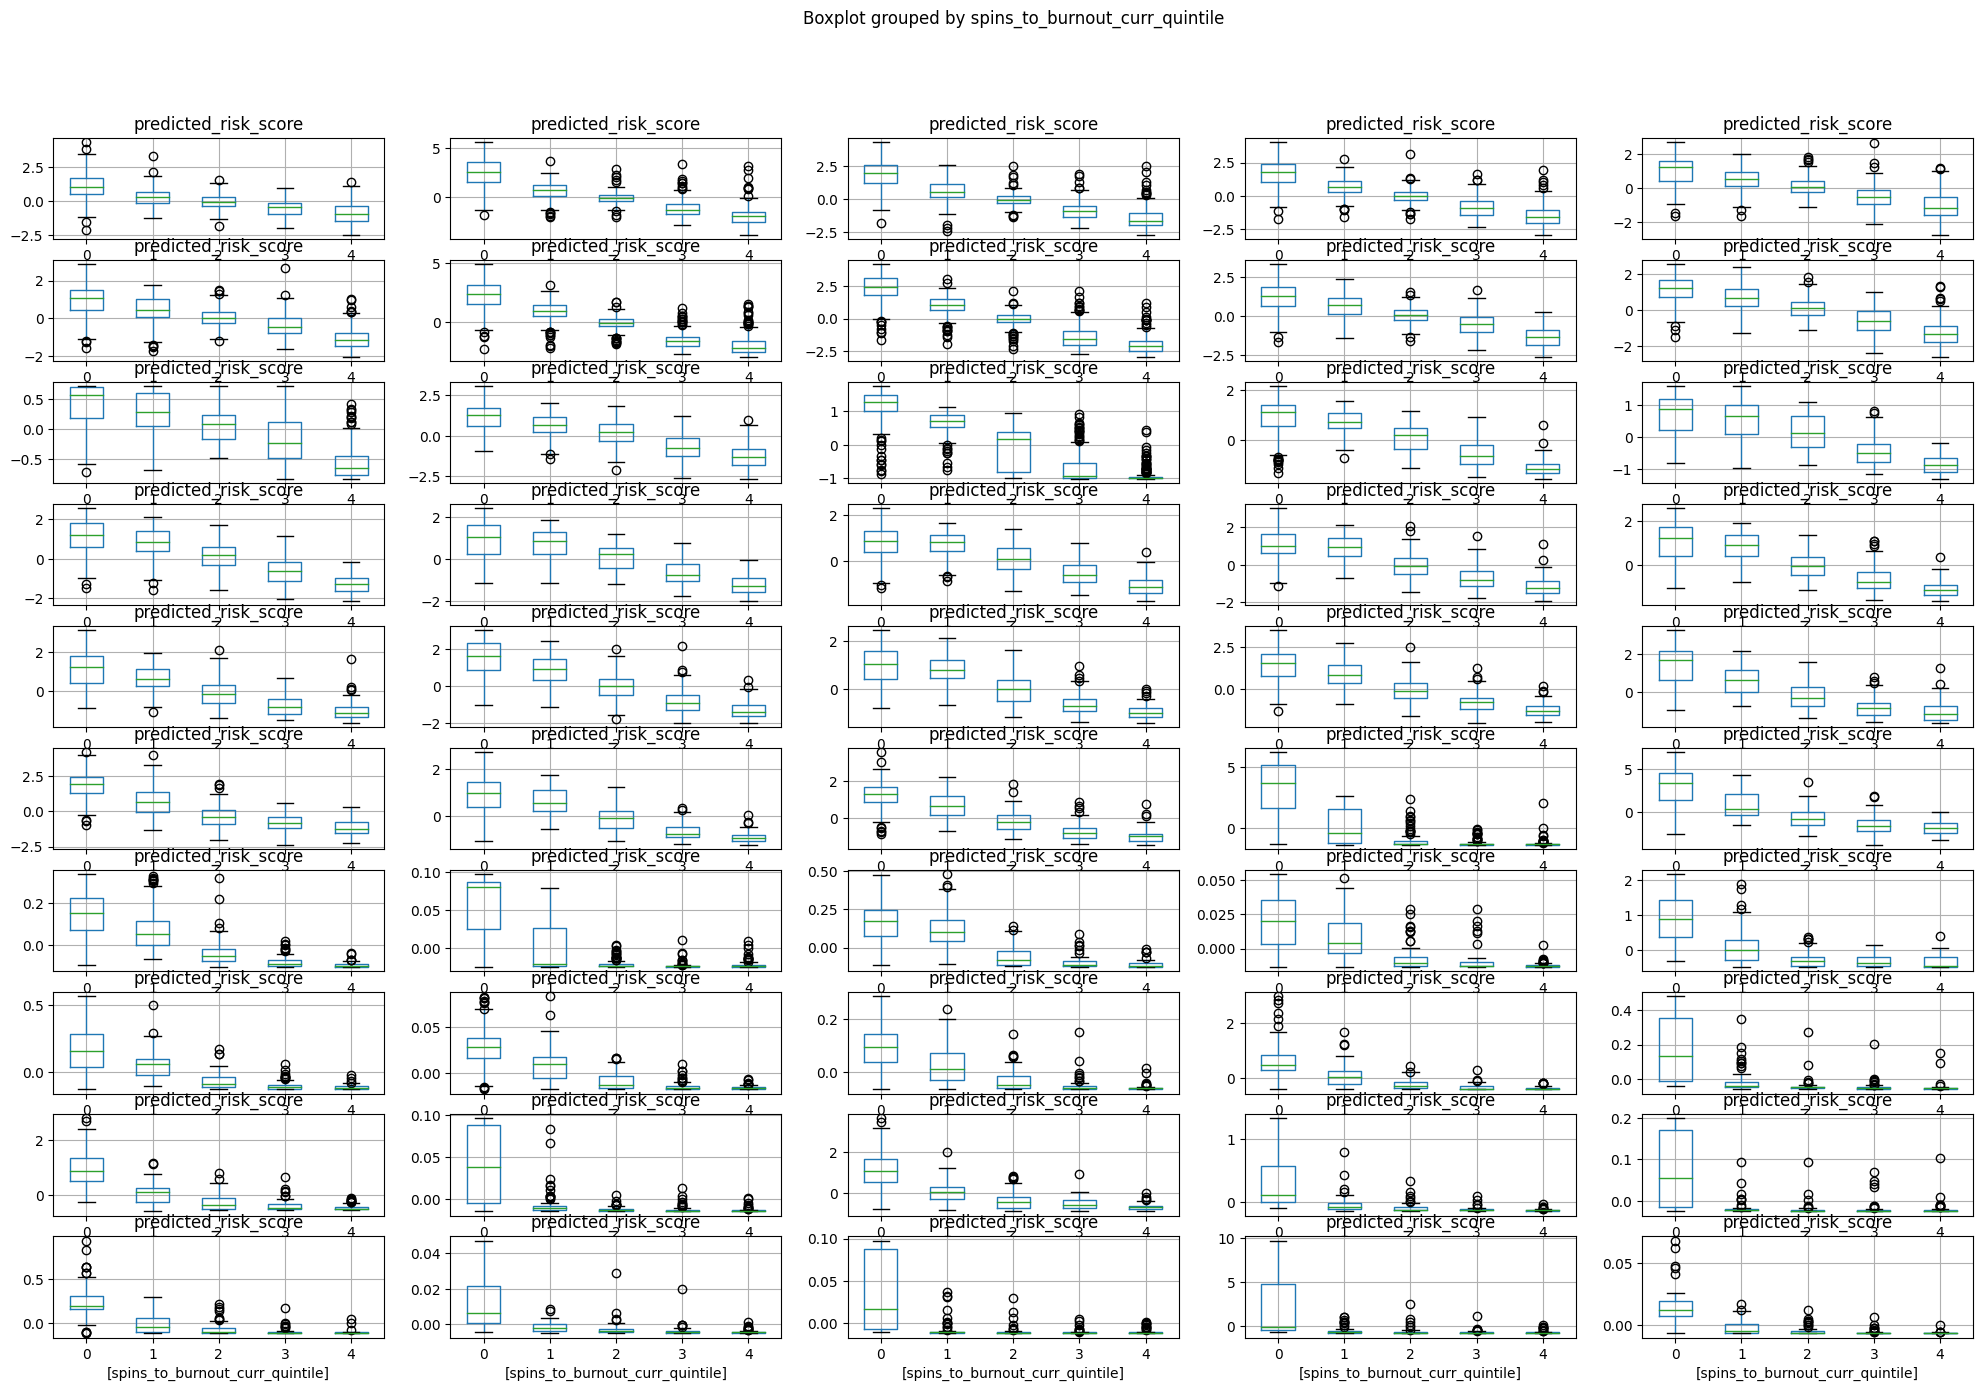

In [67]:
import matplotlib.pyplot as plt

grid = plt.GridSpec(nrows=10, ncols=5)
row_col_tuples = [(i, j) for i in range(10) for j in range(5)]
idx_count = 0
fig=plt.figure(figsize=(24, 16))
for wk in weeks_range:
    ax = fig.add_subplot(grid[row_col_tuples[idx_count][0], row_col_tuples[idx_count][1]])
    risk_scores_gbm_train[risk_scores_gbm_train['week'] == wk].boxplot(['predicted_risk_score'], by=['spins_to_burnout_curr_quintile'], ax=ax)
    # plt.ylabel('burnout risk score')
    # plt.xlabel('spins-to-burnout-quintile')
    # plt.title('Burnout risk score ranges by spins-to-burnout-quintile for Week ' + str(wk))
    idx_count=idx_count + 1

In [82]:
mask_inves = (risk_scores_gbm_train['week'] == 26) & (risk_scores_gbm_train['spins_to_burnout_curr'] == 0) & (risk_scores_gbm_train['predicted_risk_score'] < 0)
df_risk_score_inves = risk_scores_gbm_train.loc[mask_inves]

In [91]:
sel_idx = pd.MultiIndex.from_arrays([df_risk_score_inves.index.get_level_values(0), df_risk_score_inves.index.get_level_values(1)])

In [99]:
sel_idx[0]

(2687270, 'KZZP-FM')

In [100]:
df_sample_features_inves = df_features.set_index(['mediabase_id', 'call_letters']).loc[sel_idx[1]]

In [133]:
df_sample_features_inves

song_id market_name  artist_id format_code  \
mediabase_id call_letters                                                 
2516158      WKSC-FM       900032522     Chicago  739017791          H1   
             WKSC-FM       900032522     Chicago  739017791          H1   
             WKSC-FM       900032522     Chicago  739017791          H1   
             WKSC-FM       900032522     Chicago  739017791          H1   
             WKSC-FM       900032522     Chicago  739017791          H1   
...                              ...         ...        ...         ...   
             WKSC-FM       900032522     Chicago  739017791          H1   
             WKSC-FM       900032522     Chicago  739017791          H1   
             WKSC-FM       900032522     Chicago  739017791          H1   
             WKSC-FM       900032522     Chicago  739017791          H1   
             WKSC-FM       900032522     Chicago  739017791          H1   

                          song_release_date first_callout_date  \
mediabase_id call_letters                                        
2516158      WKSC-FM             2019-07-01         2020-03-09   
             WKSC-FM             2019-07-01         2020-03-09   
             WKSC-FM             2019-07-01         2020-03-09   
             WKSC-FM             2019-07-01         2020-03-09   
             WKSC-FM             2019-07-01         2020-03-09   
...                                     ...                ...   
             WKSC-FM             2019-07-01         2020-03-09   
             WKSC-FM             2019-07-01         2020-03-09   
             WKSC-FM             2019-07-01         2020-03-09   
             WKSC-FM             2019-07-01         2020-03-09   
             WKSC-FM             2019-07-01         2020-03-09   

                          last_callout_date first_spin_date last_spin_date  \
mediabase_id call_letters                                                    
2516158      WKSC-FM             2023-02-20      2019-11-24     2023-02-12   
             WKSC-FM             2023-02-20      2019-11-24     2023-02-12   
             WKSC-FM             2023-02-20      2019-11-24     2023-02-12   
             WKSC-FM             2023-02-20      2019-11-24     2023-02-12   
             WKSC-FM             2023-02-20      2019-11-24     2023-02-12   
...                                     ...             ...            ...   
             WKSC-FM             2023-02-20      2019-11-24     2023-02-12   
             WKSC-FM             2023-02-20      2019-11-24     2023-02-12   
             WKSC-FM             2023-02-20      2019-11-24     2023-02-12   
             WKSC-FM             2023-02-20      2019-11-24     2023-02-12   
             WKSC-FM             2023-02-20      2019-11-24     2023-02-12   

                          hit_tag_date  ... market_spins_propn_ftq_to_hit_std  \
mediabase_id call_letters               ...                                     
2516158      WKSC-FM        2020-09-13  ...                               NaN   
             WKSC-FM        2020-09-13  ...                               NaN   
             WKSC-FM        2020-09-13  ...                               NaN   
             WKSC-FM        2020-09-13  ...                               NaN   
             WKSC-FM        2020-09-13  ...                               NaN   
...                                ...  ...                               ...   
             WKSC-FM        2020-09-13  ...                               NaN   
             WKSC-FM        2020-09-13  ...                               NaN   
             WKSC-FM        2020-09-13  ...                               NaN   
             WKSC-FM        2020-09-13  ...                               NaN   
             WKSC-FM        2020-09-13  ...                               NaN   

                           artist_spins_propn_ftq_to_hit_min  \
mediabase_id call_letters                                    

In [109]:
inves_cols = [col for col in df_sample_features_inves.columns if 'ddl' in col and 'wk' in col and 'max' in col]

In [110]:
inves_cols

['song_station_ddl_prior_1wk_max',
 'song_format_ddl_prior_1wk_max',
 'artist_format_ddl_prior_1wk_max',
 'song_station_ddl_prior_4wk_max',
 'song_format_ddl_prior_4wk_max',
 'artist_format_ddl_prior_4wk_max',
 'song_station_ddl_prior_8wk_max',
 'song_format_ddl_prior_8wk_max',
 'artist_format_ddl_prior_8wk_max',
 'song_station_ddl_prior_13wk_max',
 'song_format_ddl_prior_13wk_max',
 'artist_format_ddl_prior_13wk_max',
 'song_station_ddl_prior_26wk_max',
 'song_format_ddl_prior_26wk_max',
 'artist_format_ddl_prior_26wk_max']

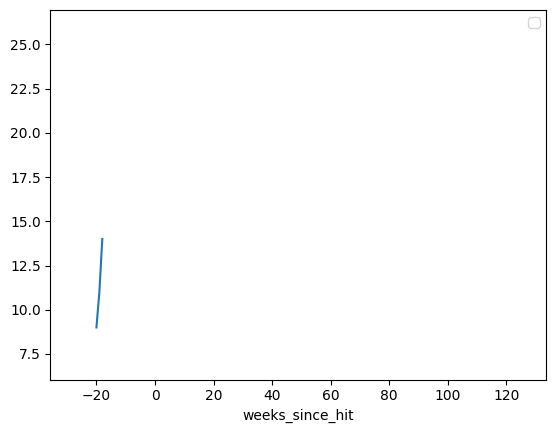

In [132]:
inves_cols=['song_station_ddl']
df_sample_features_inves[inves_cols + ['weeks_since_hit']].plot(x='weeks_since_hit')
plt.legend('')

<AxesSubplot:xlabel='weeks_since_hit', ylabel='song_station_ddl'>

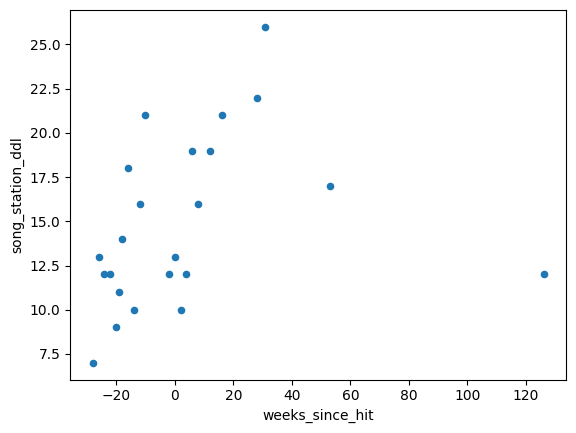

In [139]:
df_sample_features_inves[['weeks_since_hit', 'song_station_ddl']].plot(kind='scatter', x='weeks_since_hit', y='song_station_ddl')

<AxesSubplot:xlabel='weeks_since_hit', ylabel='song_station_ddl_prior_4wk_mean'>

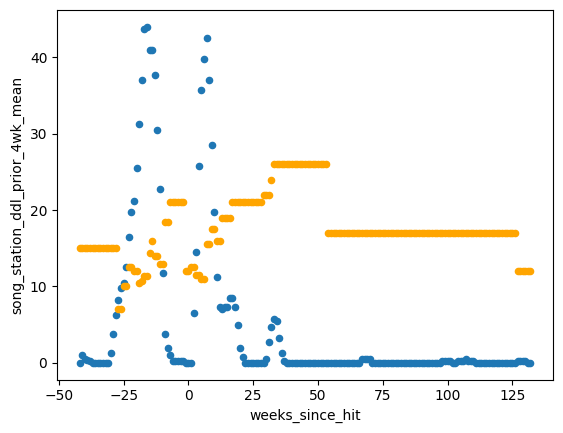

In [156]:
ax=plt.gca()
df_sample_features_inves[['weeks_since_hit', 'song_station_spins_non_on_prior_4wk_mean']].plot(kind='scatter', x='weeks_since_hit', y='song_station_spins_non_on_prior_4wk_mean', ax=ax)
df_sample_features_inves[['weeks_since_hit', 'song_station_ddl_prior_4wk_mean']].plot(kind='scatter', x='weeks_since_hit', y='song_station_ddl_prior_4wk_mean', ax=ax, c='orange')
# df_sample_features_inves[['weeks_since_hit', 'song_station_pop_prior_4wk_mean']].plot(kind='scatter', x='weeks_since_hit', y='song_station_pop_prior_4wk_mean', ax=ax, c='red')

In [121]:
df_sample_features_inves['weeks_since_hit'].values

array([-42., -41., -40., -39., -38., -37., -36., -35., -34., -33., -32.,
       -31., -30., -29., -28., -27., -26., -25., -24., -23., -22., -21.,
       -20., -19., -18., -17., -16., -15., -14., -13., -12., -11., -10.,
        -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
         2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
        13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
        24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,
        35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,
        46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,
        57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,
        68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,
        79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,
        90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100.,
       101., 102., 103., 104., 105., 106., 107., 10